In [1]:
import osmnx as ox
import networkx as nx
from networkx import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from osmnx import settings

# Erweitere Tags für detaillierte Radweg-Erkennung
settings.useful_tags_way += ["sidewalk", "cycleway", "bicycle", "cycleway:both", "cycleway:left", "cycleway:right", "bicycle_road", "cyclestreet" ]

In [3]:
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import time

from itertools import chain 
# from scipy.stats import norm
# from scipy.stats import pearsonr

# Cycleway_combined

In [ ]:
# Hilfsfunktion zur Ausgabe der Graph-Statistiken
def print_stats(graph, beschreibung):
    print(f"{beschreibung}")
    print("Anzahl der Knoten:", graph.number_of_nodes())
    print("Anzahl der Kanten:", graph.number_of_edges(), "\n")

bike_filter = '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]'
G_bike = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bike_filter, retain_all=True)
print_stats(G_bike, "bicycle-Infrastruktur:")

bicycle_designated_filter = '["bicycle"~"designated|use_sidepath|optional_sidepath"]'
G_bicycle_designated = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_designated_filter, retain_all=True)
print_stats(G_bicycle_designated, "bicycle:designated-Infrastruktur:")

bicycle_yes_filter = '["bicycle"~"yes"]["highway"!~"trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|residential|service"]'
G_bicycle_yes = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_yes_filter, retain_all=True)
print_stats(G_bicycle_yes, "bicycle:yes-Infrastruktur:")

cycleway_both_filter = '["cycleway:both"~"track"]'
G_cycleway_both = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_both_filter, retain_all=True)
print_stats(G_cycleway_both, "cycleway:both-Infrastruktur:")

cycleway_filter = '["cycleway"~"lane|share_busway|track|both|opposite|separate|opposite_track|shared|sidewalk"]'
G_cycleway = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_filter, retain_all=True)
print_stats(G_cycleway, "cycleway-Infrastruktur:")

cycleway_left_filter = '["cycleway:left"~"lane|track|shared_lane|separate"]'
G_cycleway_left = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_left_filter, retain_all=True)
print_stats(G_cycleway_both, "cycleway:left-Infrastruktur:")

cycleway_right_filter = '["cycleway:right"~"lane|track|shared_lane|separate"]'
G_cycleway_right = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_right_filter, retain_all=True)
print_stats(G_cycleway_right, "cycleway:right-Infrastruktur:")

bicycle_road_filter = '["bicycle_road"~"yes"]'
G_bicycle_road = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_road_filter, retain_all=True)
print_stats(G_bicycle_road, "bicycle_road-Infrastruktur:")

highway_cycleway_filter = '["highway"~"cycleway"]'
G_highway_cycleway = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=highway_cycleway_filter, retain_all=True)
print_stats(G_highway_cycleway, "highway_cycleway-Infrastruktur:")

# Kombinationen
Cycleway_combined = nx.compose_all([G_bike, G_cycleway_both, G_cycleway, G_cycleway_left, G_cycleway_right, G_bicycle_road, G_highway_cycleway])
print_stats(Cycleway_combined, "Gesamtkombination aller Graphen:")

Cycleway_combined_filtered = nx.compose_all([G_bicycle_designated, G_bicycle_yes, G_cycleway_both, G_cycleway, G_cycleway_left, G_cycleway_right, G_bicycle_road, G_highway_cycleway])
print_stats(Cycleway_combined_filtered, "Gesamtkombination aller Graphen:")

# 2. Langsame Straßen
slow_filter = '["maxspeed"~"^(30|20|10|7|6)$"]["access"!~"private|no"]["highway"!~"motorway|motorway_link|trunk|trunk_link"]'
G_slow = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=slow_filter, retain_all=True)
print_stats(G_slow, "Langsame Straßen:")

# Zentralitäten berechnen (gewichtet und ungewichtet)

## Betweeness berechnen

### Drive

In [26]:
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")

start_time = time.time()
# Berechne Betweenness-Zentralität
betweenness = nx.betweenness_centrality(G, normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"Betweenness-Zentralität: {duration:.4f} Sekunden")

start_time = time.time()
# Gewichtete Berechnung mit Länge der Kante
betweenness_weighted = nx.betweenness_centrality(
    G, 
    weight='length',  # Attributname der Straßenlängen
    normalized=True
)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Betweenness-Zentralität: {duration:.4f} Sekunden")

# Gewichtete Berechnung mit traveltime
G_car = ox.add_edge_speeds(G)
G_car = ox.add_edge_travel_times(G)

start_time = time.time()
betweenness_weighted_traveltime = nx.betweenness_centrality(G_car, weight='travel_time', normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Betweenness-Zentralität mit travel_time: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame mit allen Werten
df_betweenness_drive = pd.DataFrame({
    'betweenness_weighted': pd.Series(betweenness_weighted),
    'betweenness_unweighted': pd.Series(betweenness),
    'betweenness_weighted_traveltime': pd.Series(betweenness_weighted_traveltime)
})

print("Korrelationen:")
correlation = df_betweenness_drive['betweenness_weighted'].corr(df_betweenness_drive['betweenness_unweighted'])
print(f"\nKorrelation zwischen gewichteter und ungewichteter Betweeness: {correlation}")

r, p = pearsonr(df_betweenness_drive['betweenness_weighted'], df_betweenness_drive['betweenness_unweighted'])
print("Auto gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_betweenness_drive['betweenness_weighted'], df_betweenness_drive['betweenness_weighted_traveltime'])
print("Auto gewichtet vs traveltime: Korrelationskoeffizient:", r, " p-Wert:", p)


# Setzen Sie den Index-Namen (optional)
df_betweenness_drive.index.name = 'node'

print(df_betweenness_drive.head())

Betweenness-Zentralität: 9.3233 Sekunden
gewichtete Betweenness-Zentralität: 31.1992 Sekunden
gewichtete Betweenness-Zentralität mit travel_time: 18.1272 Sekunden
Korrelationen:

Korrelation zwischen gewichteter und ungewichteter Betweeness: 0.7391998722156942
Auto gewichtet vs ungewichtet: Korrelationskoeffizient: 0.7391998722156952  p-Wert: 1.392742436278912e-208
Auto gewichtet vs traveltime: Korrelationskoeffizient: 0.8798491948555396  p-Wert: 0.0
          betweenness_weighted  betweenness_unweighted  \
node                                                     
21554765              0.042373                0.043691   
21554814              0.001248                0.035907   
21554890              0.069812                0.097065   
21554967              0.047087                0.046811   
21555095              0.116145                0.074656   

          betweenness_weighted_traveltime  
node                                       
21554765                         0.034985  
215548

In [20]:
# Speichern als CSV-Datei
df_betweenness_drive.to_csv('Masterarbeit/betweenness_drive_results.csv', index=True)

### Bike

In [71]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

# Berechne Betweenness-Zentralität
start_time = time.time()
betweenness_bike = nx.betweenness_centrality(B, normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"Betweenness-Zentralität: {duration:.4f} Sekunden")

# Gewichtete Berechnung mit Länge der Kante
start_time = time.time()
betweenness_bike_weighted = nx.betweenness_centrality(
    B, 
    weight='length',  # Attributname der Straßenlängen
    normalized=True
)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Betweenness-Zentralität: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame mit allen Werten
df_betweenness_bike = pd.DataFrame({
    'betweenness_weighted': pd.Series(betweenness_bike_weighted),
    'betweenness_unweighted': pd.Series(betweenness_bike)
})

# Setzen Sie den Index-Namen (optional)
df_betweenness_bike.index.name = 'node'

correlation = df_betweenness_bike['betweenness_weighted'].corr(df_betweenness_bike['betweenness_unweighted'])
print(f"\nKorrelation zwischen gewichteter und ungewichteter Betweeness: {correlation}")

r, p = pearsonr(df_betweenness_bike['betweenness_weighted'], df_betweenness_bike['betweenness_unweighted'])
print("\nRad gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)

print(df_betweenness_bike.head())

Betweenness-Zentralität: 81.6494 Sekunden
gewichtete Betweenness-Zentralität: 217.5624 Sekunden

Korrelation zwischen gewichteter und ungewichteter Betweeness: 0.6397632730769114

Rad gewichtet vs ungewichtet: Korrelationskoeffizient: 0.6397632730769114  p-Wert: 0.0
          betweenness_weighted  betweenness_unweighted
node                                                  
21554765              0.054901                0.072567
21554814              0.000291                0.045837
21554890              0.070820                0.111060
21554967              0.079335                0.042577
21555095              0.062702                0.060597


In [21]:
# Speichern als CSV-Datei
df_betweenness_bike.to_csv('Masterarbeit/betweenness_bike_results.csv', index=True)

### Korrelation

In [17]:
print("\nKorrelation Betweeness gewichtet in Auto- und Radnetz:", df_betweenness_bike['betweenness_weighted'].corr(df_betweenness_drive['betweenness_weighted']))
print("\nKorrelation Betweeness ungewichtet in Auto- und Radnetz:", df_betweenness_bike['betweenness_unweighted'].corr(df_betweenness_drive['betweenness_unweighted']))



Korrelation Betweeness gewichtet in Auto- und Radnetz: 0.8740127002915157

Korrelation Betweeness ungewichtet in Auto- und Radnetz: 0.5693627640354426


## Edge-Betweeness berechnen

### Drive

In [8]:
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)

start_time = time.time()
# Berechne Edge-Betweenness-Zentralität
edge_betweenness = nx.edge_betweenness_centrality(G, normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"Edge-Betweenness-Zentralität: {duration:.4f} Sekunden")

start_time = time.time()
# Gewichtete Berechnung mit Länge der Kante
edge_betweenness_weighted = nx.edge_betweenness_centrality(G, weight='length', normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Edge-Betweenness-Zentralität: {duration:.4f} Sekunden")

# # Gewichtete Berechnung mit traveltime
G_car = ox.add_edge_speeds(G)
G_car = ox.add_edge_travel_times(G)

start_time = time.time()
edge_betweenness_weighted_traveltime = nx.edge_betweenness_centrality(G_car, weight='travel_time', normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Edge-Betweenness-Zentralität mit travel_time: {duration:.4f} Sekunden")

# Erstelle den DataFrame mit allen Werten
df_edge_betweenness = pd.DataFrame({
    'edge_betweenness_weighted': pd.Series(edge_betweenness_weighted),
    'edge_betweenness_unweighted': pd.Series(edge_betweenness),
    'edge_betweenness_traveltime': pd.Series(edge_betweenness_weighted_traveltime)
})

# Setze den Index-Namen
df_edge_betweenness.index.name = 'edge'

print(df_edge_betweenness.head())

print("Korrelationen:")
# correlation = df_edge_betweenness['edge_betweenness_weighted': pd.Series(edge_betweenness_weighted)].corr(df_edge_betweenness['edge_betweenness_unweighted'])
# print(f"\nKorrelation zwischen gewichteter und ungewichteter Betweeness: {correlation}")

r, p = pearsonr(df_edge_betweenness['edge_betweenness_weighted'], df_edge_betweenness['edge_betweenness_unweighted'])
print("Auto gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_edge_betweenness['edge_betweenness_weighted'], df_edge_betweenness['edge_betweenness_traveltime'])
print("Auto gewichtet vs traveltime: Korrelationskoeffizient:", r, " p-Wert:", p)

Edge-Betweenness-Zentralität: 4.5439 Sekunden
gewichtete Edge-Betweenness-Zentralität: 14.5559 Sekunden
gewichtete Edge-Betweenness-Zentralität mit travel_time: 14.7339 Sekunden
                       edge_betweenness_weighted  edge_betweenness_unweighted  \
21554765 1468104126 0                   0.000555                     0.000772   
         312264418  0                   0.022505                     0.027689   
         1468116628 0                   0.020066                     0.015981   
21554814 21554765   0                   0.001440                     0.017905   
         1468116628 0                   0.000630                     0.018767   

                       edge_betweenness_traveltime  
21554765 1468104126 0                     0.000646  
         312264418  0                     0.018296  
         1468116628 0                     0.016809  
21554814 21554765   0                     0.001946  
         1468116628 0                     0.006613  
Korrelationen:
Au

In [50]:
# Speichern als CSV-Datei
df_edge_betweenness.to_csv('Masterarbeit/edge_betweenness_results.csv', index=True)

### Bike

In [7]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

# Berechne Edge-Betweenness-Zentralität
start_time = time.time()
edge_betweenness_bike = nx.edge_betweenness_centrality(B, normalized=True)
duration = time.time() - start_time
print(f"ungewichtete Edge-Betweenness-Zentralität: {duration:.4f} Sekunden")


# Gewichtete Berechnung mit Länge der Kante
start_time = time.time()
edge_betweenness_bike_weighted = nx.edge_betweenness_centrality(B, weight='length', normalized=True)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Edge-Betweenness-Zentralität: {duration:.4f} Sekunden")

# Erstelle den DataFrame mit allen Werten
df_edge_betweenness_bike = pd.DataFrame({
    'edge_betweenness_weighted': pd.Series(edge_betweenness_bike_weighted),
    'edge_betweenness_unweighted': pd.Series(edge_betweenness_bike)
})

# Setze den Index-Namen
df_edge_betweenness_bike.index.name = 'edge'

print(df_edge_betweenness_bike.head())

correlation = df_edge_betweenness_bike['edge_betweenness_weighted'].corr(df_edge_betweenness_bike['edge_betweenness_unweighted'])
print(f"\nKorrelation zwischen gewichteter und ungewichteter Betweeness: {correlation}")

r, p = pearsonr(df_edge_betweenness_bike['edge_betweenness_weighted'], df_edge_betweenness_bike['edge_betweenness_unweighted'])
print("\nRad gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)

ungewichtete Edge-Betweenness-Zentralität: 85.4045 Sekunden
gewichtete Edge-Betweenness-Zentralität: 217.7189 Sekunden
                       edge_betweenness_weighted  edge_betweenness_unweighted
21554765 5245776287 0                   0.027544                     0.037783
         1468116628 0                   0.027565                     0.034984
21554814 21554765   0                   0.000277                     0.017369
         1468116628 0                   0.000247                     0.028680
21554890 3598500533 0                   0.014683                     0.032782

Korrelation zwischen gewichteter und ungewichteter Betweeness: 0.5603337318549373

Rad gewichtet vs ungewichtet: Korrelationskoeffizient: 0.5603337318549375  p-Wert: 0.0


In [8]:
# Speichern als CSV-Datei
df_edge_betweenness_bike.to_csv(
    'Masterarbeit/edge_betweenness_bike_results.csv', 
    index=True, 
    header=True)

In [15]:
# Anzahl der berechneten Betweeness-Werte
num_betweenness = len(edge_betweenness_bike_weighted)

# Anzahl der Kanten im Graphen B
num_edges = B.number_of_edges()

print(f"Anzahl Betweeness-Werte: {num_betweenness}")
print(f"Anzahl Kanten im Graphen: {num_edges}")

Anzahl Betweeness-Werte: 9958
Anzahl Kanten im Graphen: 9958


In [15]:
missing_edges = set(B.edges()) - set(edge_betweenness_bike_weighted.keys())
print(len(missing_edges))
print(len(B.edges()))
print(len(edge_betweenness_bike_weighted.keys()))


9846
9958
9958


## Closeness berechnen

### Drive

In [7]:
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")

# Berechne gewichtete Closeness-Zentralität (standardmäßig normalisert)
start_time = time.time()
closeness_weighted = nx.closeness_centrality(G, distance='length')
duration = time.time() - start_time
print(f"gewichtete Zentralität: {duration:.4f} Sekunden")


# Berechne ungewichtete Closeness-Zentralität zum Vergleich
start_time = time.time()
closeness = nx.closeness_centrality(G)
duration = time.time() - start_time
print(f"Zentralität: {duration:.4f} Sekunden")

# Gewichtete Berechnung mit traveltime

G_car = ox.add_edge_speeds(G)
G_car = ox.add_edge_travel_times(G)

start_time = time.time()
closeness_weighted_traveltime = nx.closeness_centrality(G_car, distance='travel_time')
duration = time.time() - start_time
print(f"gewichtete Zentralität (travel_time): {duration:.4f} Sekunden")


# Erstellen Sie den DataFrame mit allen Werten
df_closeness = pd.DataFrame({
    'closeness_weighted': pd.Series(closeness_weighted),
    'closeness_unweighted': pd.Series(closeness),
    'closeness_weighted_traveltime': pd.Series(closeness_weighted_traveltime)
})

# Setzen Sie den Index-Namen
df_closeness.index.name = 'node'

print(df_closeness.head())

# Optional: Berechnen Sie die Korrelation zwischen gewichteter und ungewichteter Closeness
correlation = df_closeness['closeness_weighted'].corr(df_closeness['closeness_unweighted'])
print(f"Korrelation zwischen gewichteter und ungewichteter Closeness: {correlation}")

r, p = pearsonr(df_closeness['closeness_weighted'], df_closeness['closeness_unweighted'])
print("Korrelationskoeffizient:", r, " p-Wert:", p)

# Quantitativer Vergleich der Top-100-Knoten
top_unweighted = df_closeness.nlargest(100, 'closeness_unweighted').index
top_weighted = df_closeness.nlargest(100, 'closeness_weighted').index
overlap = len(set(top_unweighted) & set(top_weighted))

print(f"Überlappung Top-100: {overlap} Knoten")


gewichtete Zentralität: 5.8727 Sekunden
Zentralität: 0.8416 Sekunden
gewichtete Zentralität (travel_time): 5.9183 Sekunden
          closeness_weighted  closeness_unweighted  \
node                                                 
21554765            0.000364              0.048166   
21554814            0.000280              0.048030   
21554890            0.000502              0.053828   
21554967            0.000433              0.047313   
21555095            0.000518              0.053806   

          closeness_weighted_traveltime  
node                                     
21554765                       0.004407  
21554814                       0.003619  
21554890                       0.005861  
21554967                       0.005292  
21555095                       0.005967  
Korrelation zwischen gewichteter und ungewichteter Closeness: 0.8869964195560979
Korrelationskoeffizient: 0.8869964195560982  p-Wert: 0.0
Überlappung Top-100: 66 Knoten


### Bike

In [6]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

# Berechne gewichtete Closeness-Zentralität (standardmäßig normalisert)
start_time = time.time()
closeness_bike_weighted = nx.closeness_centrality(B, distance='length')
duration = time.time() - start_time
print(f"gewichtete Zentralität: {duration:.4f} Sekunden")

# Berechne ungewichtete Closeness-Zentralität zum Vergleich
start_time = time.time()
closeness_bike = nx.closeness_centrality(B)
duration = time.time() - start_time
print(f"Zentralität: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame mit allen Werten
df_closeness_bike = pd.DataFrame({
    'closeness_weighted': pd.Series(closeness_bike_weighted),
    'closeness_unweighted': pd.Series(closeness_bike)
})

# Setzen Sie den Index-Namen
df_closeness_bike.index.name = 'node'

print(df_closeness_bike.head())

# Optional: Berechnen Sie die Korrelation zwischen gewichteter und ungewichteter Closeness
correlation = df_closeness_bike['closeness_weighted'].corr(df_closeness_bike['closeness_unweighted'])
print(f"Korrelation zwischen gewichteter und ungewichteter Closeness: {correlation}")

r, p = pearsonr(df_closeness_bike['closeness_weighted'], df_closeness_bike['closeness_unweighted'])
print("Korrelationskoeffizient:", r, " p-Wert:", p)

# Quantitativer Vergleich der Top-100-Knoten
top_unweighted = df_closeness_bike.nlargest(100, 'closeness_unweighted').index
top_weighted = df_closeness_bike.nlargest(100, 'closeness_weighted').index
overlap = len(set(top_unweighted) & set(top_weighted))

print(f"\nÜberlappung Top-100: {overlap} Knoten")


gewichtete Zentralität: 91.4669 Sekunden
Zentralität: 13.8580 Sekunden
          closeness_weighted  closeness_unweighted
node                                              
21554765            0.000352              0.032441
21554814            0.000274              0.031484
21554890            0.000492              0.035358
21554967            0.000433              0.029969
21555095            0.000503              0.035834
Korrelation zwischen gewichteter und ungewichteter Closeness: 0.9168712310873567
Korrelationskoeffizient: 0.916871231087357  p-Wert: 0.0
Überlappung Top-100: 64 Knoten


### Korrelation

In [10]:
print("Korrelation Closeness ungewichtet in Auto- und Radnetz:", df_closeness['closeness_unweighted'].corr(df_closeness_bike['closeness_unweighted']))
print("Korrelation Closeness gewichtet in Auto- und Radnetz:", df_closeness['closeness_weighted'].corr(df_closeness_bike['closeness_weighted']))

Korrelation Closeness ungewichtet in Auto- und Radnetz: 0.8540419577445861
Korrelation Closeness gewichtet in Auto- und Radnetz: 0.9816314472298032


## Eigenvector berechnen

### Drive

In [32]:
# Konvertieren Sie den Multigraphen in einen einfachen Graphen
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
G_simple = nx.Graph(G)

# Berechne Eigenvector-Zentralität (standardmäßig normalisert)
start_time = time.time()
eigenvector = nx.eigenvector_centrality(G_simple, max_iter=1000)
duration = time.time() - start_time
print(f"Eigenvector-Zentralität: {duration:.4f} Sekunden")

# Gewichtete Berechnung mit Länge der Kante
start_time = time.time()
eigenvector_weighted = nx.eigenvector_centrality(G_simple, weight='length', max_iter=1000)
duration = time.time() - start_time
print(f"gewichtete Eigenvector-Zentralität: {duration:.4f} Sekunden")


# Gewichtete Berechnung mit traveltime
G_car = ox.add_edge_speeds(G)
G_car = ox.add_edge_travel_times(G)

for u, v, data in G_car.edges(data=True):
    tt = data.get('travel_time', 1)
    data['inv_travel_time'] = 1 / tt if tt > 0 else 0  # Vermeide Division durch 0

G_car_simple = nx.Graph(G_car)

start_time = time.time()
eigenvector_weighted_traveltime = nx.eigenvector_centrality(G_car_simple, weight='travel_time', max_iter=1000)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"gewichtete Zentralität mit travel_time: {duration:.4f} Sekunden")

eigenvector_weighted_invtraveltime = nx.eigenvector_centrality(G_car_simple, weight='inv_travel_time', max_iter=1000)


# Erstellen Sie den DataFrame
df_eigenvector = pd.DataFrame.from_dict(eigenvector, orient='index', columns=['eigenvector_unweighted'])
df_eigenvector['eigenvector_weighted'] = pd.Series(eigenvector_weighted)
df_eigenvector['eigenvector_weighted_traveltime'] = pd.Series(eigenvector_weighted_traveltime)

# Setzen Sie den Index-Namen (optional)
df_eigenvector.index.name = 'node'

print(df_eigenvector.head())

print("\nKorrelationen:")
correlation = df_eigenvector['eigenvector_weighted'].corr(df_eigenvector['eigenvector_unweighted'])
print(f"\nKorrelation zwischen gewichteter und ungewichteter: {correlation}")

r, p = pearsonr(df_eigenvector['eigenvector_weighted'], df_eigenvector['eigenvector_unweighted'])
print("Auto gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_eigenvector['eigenvector_weighted'], df_eigenvector['eigenvector_weighted_traveltime'])
print("Auto gewichtet vs traveltime: Korrelationskoeffizient:", r, " p-Wert:", p)


Eigenvector-Zentralität: 0.9124 Sekunden
gewichtete Eigenvector-Zentralität: 4.2182 Sekunden
gewichtete Zentralität mit travel_time: 0.9796 Sekunden
          eigenvector_unweighted  eigenvector_weighted  \
node                                                     
21554765                0.000042          2.275960e-44   
21554814                0.000052          1.368244e-42   
21554890                0.000831          9.224382e-48   
21554967                0.001801          3.047807e-55   
21555095                0.000974          5.527719e-45   

          eigenvector_weighted_traveltime  
node                                       
21554765                     2.301255e-15  
21554814                     2.761498e-15  
21554890                     1.230892e-21  
21554967                     5.403504e-25  
21555095                     2.846853e-22  

Korrelationen:

Korrelation zwischen gewichteter und ungewichteter: -0.011706316101238989
Auto gewichtet vs ungewichtet: Korrelationsko

### Bike

In [33]:
# Konvertieren Sie den Multigraphen in einen einfachen Graphen
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
G_simple = nx.Graph(B)

start_time = time.time()
eigenvector_bike = nx.eigenvector_centrality(G_simple, max_iter=5000)
duration = time.time() - start_time
print(f"Eigenvector-Zentralität: {duration:.4f} Sekunden")

# Gewichtete Berechnung mit Länge der Kante
start_time = time.time()
eigenvector_weighted_bike = nx.eigenvector_centrality(G_simple, weight='length', max_iter=5000)
duration = time.time() - start_time
print(f"gewichtete Eigenvector-Zentralität: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame
df_eigenvector_bike = pd.DataFrame.from_dict(eigenvector_weighted_bike, orient='index', columns=['eigenvector_weighted'])
df_eigenvector_bike['eigenvector'] = pd.Series(eigenvector_bike)
# Setzen Sie den Index-Namen (optional)
df_eigenvector_bike.index.name = 'node'

print(df_eigenvector_bike.head())

print("\nKorrelationen:")
correlation = df_eigenvector_bike['eigenvector_weighted'].corr(df_eigenvector_bike['eigenvector'])
print(f"\nKorrelation zwischen gewichteter und ungewichteter: {correlation}")

r, p = pearsonr(df_eigenvector_bike['eigenvector_weighted'], df_eigenvector_bike['eigenvector'])
print("Bike gewichtet vs ungewichtet: Korrelationskoeffizient:", r, " p-Wert:", p)


Eigenvector-Zentralität: 0.5620 Sekunden
gewichtete Eigenvector-Zentralität: 44.0267 Sekunden
          eigenvector_weighted  eigenvector
node                                       
21554765          1.999358e-05     0.000017
21554814          4.150572e-05     0.000009
21554890          9.149029e-11     0.000060
21554967          1.710347e-28     0.000021
21555095          5.017212e-12     0.000089

Korrelationen:

Korrelation zwischen gewichteter und ungewichteter: -0.0021137258430504184
Bike gewichtet vs ungewichtet: Korrelationskoeffizient: -0.002113725843050412  p-Wert: 0.8901119923533226


### Korrelation

In [34]:
print("\nKorrelationen:")
correlation = df_eigenvector['eigenvector_weighted'].corr(df_eigenvector_bike['eigenvector_weighted'])
print(f"\nKorrelation zwischen Auto und Rad gewichtet: {correlation}")

correlation = df_eigenvector['eigenvector_unweighted'].corr(df_eigenvector_bike['eigenvector'])
print(f"\nKorrelation zwischen Auto und Rad ungewichtet: {correlation}")


Korrelationen:

Korrelation zwischen Auto und Rad gewichtet: -0.0015551919143426936

Korrelation zwischen Auto und Rad ungewichtet: 0.6624679172405027


## Degree berechnen

### Drive

In [13]:
# Berechne Degree-Zentralität
start_time = time.time()
degree = nx.degree_centrality(G)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"Degree-Zentralität: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame
df_degree = pd.DataFrame.from_dict(degree, orient='index', columns=['degree_centrality'])

# Setzen Sie den Index-Namen (optional)
df_degree.index.name = 'node'

print(df_degree.head())

Degree-Zentralität: 0.0061 Sekunden
          degree_centrality
node                       
21554765           0.004988
21554814           0.002494
21554890           0.003325
21554967           0.003325
21555095           0.004156


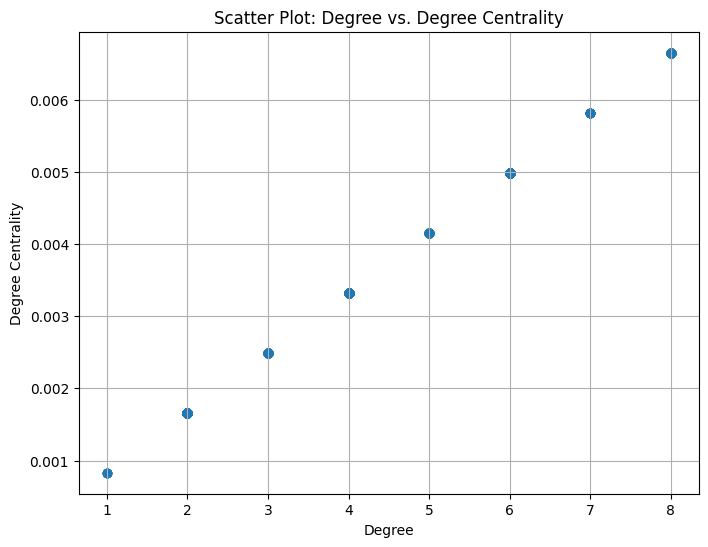

In [24]:
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")

G_simple = nx.Graph(G)

# Berechne Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Berechne den Grad jedes Knotens
degrees = [G.degree(n) for n in G.nodes()]

# Hole die Centrality-Werte in der gleichen Reihenfolge
centrality_values = [degree_centrality[n] for n in G.nodes()]

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(degrees, centrality_values, alpha=0.7)
plt.xlabel("Degree")
plt.ylabel("Degree Centrality")
plt.title("Scatter Plot: Degree vs. Degree Centrality")
plt.grid(True)
plt.show()

In [25]:
# Werte von G.degree
degree_values = [deg for _, deg in G.degree()]
unique_degrees = set(degree_values)
print("Mögliche Werte von G.degree:", sorted(unique_degrees))

# Werte von "street_count" Attribut
street_counts = [data.get("street_count") for _, data in G.nodes(data=True) if "street_count" in data]
unique_street_counts = set(street_counts)
print('Mögliche Werte im Attribut "street_count":', sorted(unique_street_counts))

Mögliche Werte von G.degree: [1, 2, 3, 4, 5, 6, 7, 8]
Mögliche Werte im Attribut "street_count": [1, 2, 3, 4, 5, 6]


In [28]:
from collections import Counter

G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")

G_simple = nx.Graph(G)

# Knotengrade und deren Häufigkeit
degree_values = [deg for _, deg in G.degree()]
degree_counts = Counter(degree_values)
print("Knotengrade und ihre Häufigkeiten:")
for degree, count in sorted(degree_counts.items()):
    print(f"Grad {degree}: {count} Knoten")
    
# Knotengrade und deren Häufigkeit
degree_values_simple = [deg for _, deg in G_simple.degree()]
degree_counts_simple = Counter(degree_values_simple)
print("\nKnotengrade und ihre Häufigkeiten im vereinfachten Graphen:")
for degree, count in sorted(degree_counts_simple.items()):
    print(f"Grad {degree}: {count} Knoten")

# Werte des Attributs "street_count" und deren Häufigkeit
street_counts = [data.get("street_count") for _, data in G.nodes(data=True) if "street_count" in data]
street_count_freq = Counter(street_counts)
print('\nWerte des Attributs "street_count" und ihre Häufigkeiten:')
for val, count in sorted(street_count_freq.items()):
    print(f"street_count = {val}: {count} Knoten")

Knotengrade und ihre Häufigkeiten:
Grad 1: 7 Knoten
Grad 2: 225 Knoten
Grad 3: 98 Knoten
Grad 4: 150 Knoten
Grad 5: 77 Knoten
Grad 6: 532 Knoten
Grad 7: 16 Knoten
Grad 8: 99 Knoten

Knotengrade und ihre Häufigkeiten im vereinfachten Graphen:
Grad 1: 225 Knoten
Grad 2: 60 Knoten
Grad 3: 741 Knoten
Grad 4: 171 Knoten
Grad 5: 6 Knoten
Grad 6: 1 Knoten

Werte des Attributs "street_count" und ihre Häufigkeiten:
street_count = 1: 219 Knoten
street_count = 2: 17 Knoten
street_count = 3: 779 Knoten
street_count = 4: 182 Knoten
street_count = 5: 6 Knoten
street_count = 6: 1 Knoten


In [29]:
# Datenpaare filtern, bei denen street_count=None
filtered_data = [
    (d, s) 
    for d, s in zip(degree_values_simple, street_counts) 
    if s is not None
]

if filtered_data:
    degrees, streets = zip(*filtered_data)
    correlation, p_value = pearsonr(degrees, streets)
    print(f"Korrelationskoeffizient: {correlation}")
    print(f"p-Wert: {p_value}")
else:
    print("Keine gültigen Datenpaare für die Berechnung vorhanden")


Korrelationskoeffizient: 0.9641936062760396
p-Wert: 0.0


### Bike

In [6]:
# Berechne Degree-Zentralität
start_time = time.time()
bike_degree = nx.degree_centrality(B)
# Zeitmessung beenden
duration = time.time() - start_time
print(f"Degree-Zentralität: {duration:.4f} Sekunden")

# Erstellen Sie den DataFrame
df_bike_degree = pd.DataFrame.from_dict(bike_degree, orient='index', columns=['degree_centrality'])

# Setzen Sie den Index-Namen (optional)
df_bike_degree.index.name = 'node'

print(df_bike_degree.head())

Degree-Zentralität: 0.0237 Sekunden
          degree_centrality
node                       
21554765           0.001170
21554814           0.000702
21554890           0.000936
21554967           0.000936
21555095           0.001170


In [7]:
from collections import Counter

G = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

G_simple = nx.Graph(G)

# Knotengrade und deren Häufigkeit
degree_values = [deg for _, deg in G.degree()]
degree_counts = Counter(degree_values)
print("Knotengrade und ihre Häufigkeiten:")
for degree, count in sorted(degree_counts.items()):
    print(f"Grad {degree}: {count} Knoten")
    
# Knotengrade und deren Häufigkeit
degree_values_simple = [deg for _, deg in G_simple.degree()]
degree_counts_simple = Counter(degree_values_simple)
print("\nKnotengrade und ihre Häufigkeiten im vereinfachten Graphen:")
for degree, count in sorted(degree_counts_simple.items()):
    print(f"Grad {degree}: {count} Knoten")

# Werte des Attributs "street_count" und deren Häufigkeit
street_counts = [data.get("street_count") for _, data in G.nodes(data=True) if "street_count" in data]
street_count_freq = Counter(street_counts)
print('\nWerte des Attributs "street_count" und ihre Häufigkeiten:')
for val, count in sorted(street_count_freq.items()):
    print(f"street_count = {val}: {count} Knoten")


Knotengrade und ihre Häufigkeiten:
Grad 1: 9 Knoten
Grad 2: 1302 Knoten
Grad 3: 118 Knoten
Grad 4: 285 Knoten
Grad 5: 136 Knoten
Grad 6: 2127 Knoten
Grad 7: 24 Knoten
Grad 8: 270 Knoten
Grad 9: 1 Knoten
Grad 10: 3 Knoten

Knotengrade und ihre Häufigkeiten im vereinfachten Graphen:
Grad 1: 1309 Knoten
Grad 2: 181 Knoten
Grad 3: 2332 Knoten
Grad 4: 435 Knoten
Grad 5: 16 Knoten
Grad 6: 1 Knoten
Grad 7: 1 Knoten

Werte des Attributs "street_count" und ihre Häufigkeiten:
street_count = 1: 1295 Knoten
street_count = 2: 27 Knoten
street_count = 3: 2474 Knoten
street_count = 4: 458 Knoten
street_count = 5: 19 Knoten
street_count = 6: 1 Knoten
street_count = 7: 1 Knoten


In [27]:
# Datenpaare filtern, bei denen street_count=None
filtered_data = [
    (d, s) 
    for d, s in zip(degree_values_simple, street_counts) 
    if s is not None
]

if filtered_data:
    degrees, streets = zip(*filtered_data)
    correlation, p_value = pearsonr(degrees, streets)
    print(f"Korrelationskoeffizient: {correlation}")
    print(f"p-Wert: {p_value}")
else:
    print("Keine gültigen Datenpaare für die Berechnung vorhanden")


Korrelationskoeffizient: 0.9741958975922127
p-Wert: 0.0


### Korrelation

In [36]:
print("\nKorrelation Betweeness gewichtet in Auto- und Radnetz:", 
      df_degree['degree_centrality'].corr(df_bike_degree['degree_centrality']))


Korrelation Betweeness gewichtet in Auto- und Radnetz: 0.9142338237488637


## Korrelation zwischen den Maßen

### Drive

In [39]:
r, p = pearsonr(df_closeness['closeness_weighted'], df_betweenness_drive['betweenness_weighted'])
print("Auto gewichtet Closeness zu Betweeness: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_closeness['closeness_unweighted'], df_betweenness_drive['betweenness_unweighted'])
print("Auto ungewichtet Closeness zu Betweeness: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_closeness['closeness_unweighted'], df_eigenvector['eigenvector_unweighted'])
print("Auto ungewichtet Closeness zu eigenvektor: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_betweenness_drive['betweenness_unweighted'], df_eigenvector['eigenvector_unweighted'])
print("Auto ungewichtet Betweeness eigenvektor: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_betweenness_drive['betweenness_unweighted'], df_degree['degree_centrality'])
print("Auto ungewichtet Betweeness degree: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_degree['degree_centrality'], df_betweenness_drive['betweenness_unweighted'])
print("Auto ungewichtet Betweeness degree: Korrelationskoeffizient:", r, " p-Wert:", p)

Auto gewichtet Closeness zu Betweeness: Korrelationskoeffizient: 0.4544022466127039  p-Wert: 2.1722251448109114e-62
Auto ungewichtet Closeness zu Betweeness: Korrelationskoeffizient: 0.46479299187808915  p-Wert: 1.4671134357972668e-65
Auto ungewichtet Closeness zu eigenvektor: Korrelationskoeffizient: 0.07376179893799052  p-Wert: 0.010459131078999742
Auto ungewichtet Betweeness eigenvektor: Korrelationskoeffizient: 0.02944381410826747  p-Wert: 0.3073386459797962
Auto ungewichtet Betweeness degree: Korrelationskoeffizient: 0.2360971344536553  p-Wert: 1.0290380069242373e-16
Auto ungewichtet Betweeness degree: Korrelationskoeffizient: 0.2360971344536553  p-Wert: 1.0290380069242373e-16


### Bike

In [40]:
r, p = pearsonr(df_closeness_bike['closeness_weighted'], df_betweenness_bike['betweenness_weighted'])
print("gewichtet Closeness zu Betweeness: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_closeness_bike['closeness_unweighted'], df_betweenness_bike['betweenness_unweighted'])
print("ungewichtet Closeness zu Betweeness: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_closeness_bike['closeness_unweighted'], df_eigenvector_bike['eigenvector'])
print("ungewichtet Closeness zu eigenvektor: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_betweenness_bike['betweenness_unweighted'], df_eigenvector_bike['eigenvector'])
print("ungewichtet Betweeness eigenvektor: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_betweenness_bike['betweenness_unweighted'], df_bike_degree['degree_centrality'])
print("ungewichtet Betweeness degree: Korrelationskoeffizient:", r, " p-Wert:", p)

r, p = pearsonr(df_bike_degree['degree_centrality'], df_betweenness_bike['betweenness_unweighted'])
print("ungewichtet Betweeness degree: Korrelationskoeffizient:", r, " p-Wert:", p)

gewichtet Closeness zu Betweeness: Korrelationskoeffizient: 0.34104093408650105  p-Wert: 6.667014153408127e-117
ungewichtet Closeness zu Betweeness: Korrelationskoeffizient: 0.3656738540534219  p-Wert: 2.150553549465761e-135
ungewichtet Closeness zu eigenvektor: Korrelationskoeffizient: 0.10435975647797258  p-Wert: 7.91419341849331e-12
ungewichtet Betweeness eigenvektor: Korrelationskoeffizient: 0.09640934864104034  p-Wert: 2.6763396224739016e-10
ungewichtet Betweeness degree: Korrelationskoeffizient: 0.2866920835477291  p-Wert: 1.1141778917206374e-81
ungewichtet Betweeness degree: Korrelationskoeffizient: 0.2866920835477291  p-Wert: 1.1141778917206374e-81


# Zentralitäten darstellen

## Betweeness

### Histogramm

#### Drive

/tmp/ipykernel_25/343133945.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


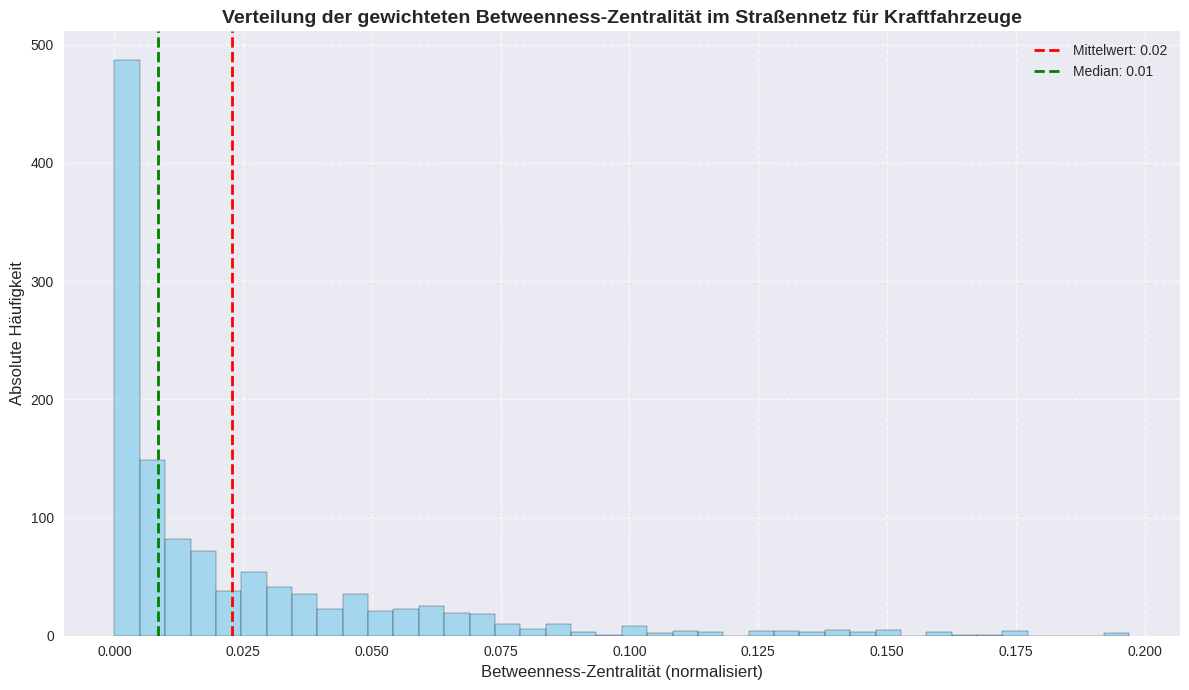

In [12]:
# Extrahieren Sie die Betweenness-Werte aus dem DataFrame
betweenness_values = df_betweenness_drive['betweenness_weighted'].values


# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(betweenness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='skyblue', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(betweenness_values)
median_value = np.median(betweenness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Beschriftungen und Titel
plt.xlabel('Betweenness-Zentralität (normalisiert)', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der gewichteten Betweenness-Zentralität im Straßennetz für Kraftfahrzeuge', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=10)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/betweenness_verteilung_drive.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()



/tmp/ipykernel_25/580489840.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


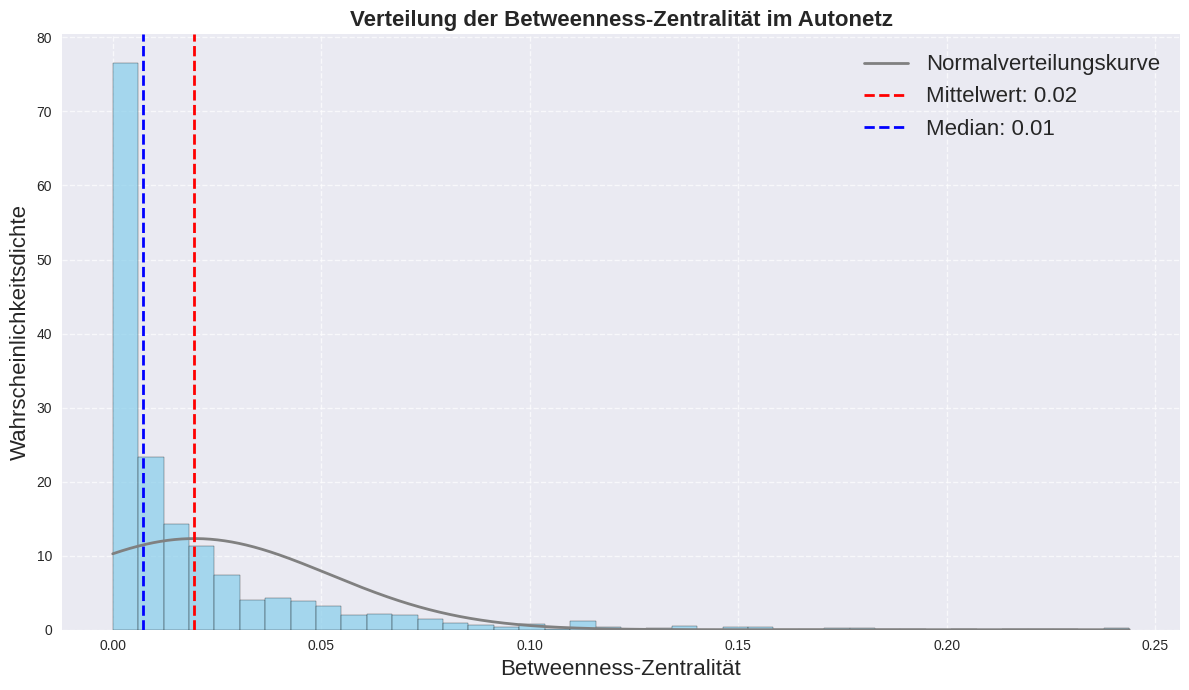

In [19]:
from scipy.stats import norm

# Betweenness-Werte extrahieren
betweenness_values = df_betweenness_drive['betweenness_unweighted'].values

# Stil setzen
plt.style.use('seaborn')

# Histogramm mit density=True (y-Achse ist Wahrscheinlichkeitsdichte)
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(
    betweenness_values, bins=40, edgecolor='black',
    alpha=0.7, color='skyblue', density=True
)

# Mittelwert und Standardabweichung berechnen
mean_value = np.mean(betweenness_values)
std_value = np.std(betweenness_values)

# Normalverteilungskurve berechnen
x = np.linspace(min(betweenness_values), max(betweenness_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Mittelwert und Median einzeichnen
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.2f}')
plt.axvline(np.median(betweenness_values), color='blue', linestyle='dashed', linewidth=2, label=f'Median: {np.median(betweenness_values):.2f}')

# Achsenbeschriftungen und Titel
plt.xlabel('Betweenness-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Betweenness-Zentralität im Autonetz', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()

# Speichern und Anzeigen
plt.savefig('Masterarbeit/betweenness_verteilung_drive.png', dpi=300, bbox_inches='tight')
plt.show()



#### Bike

In [50]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

# Gewichtete Berechnung mit Länge der Kante
betweenness_bike_weighted = nx.betweenness_centrality(
    B, 
    weight='length',  # Attributname der Straßenlängen
    normalized=True
)
# Erstellen Sie den DataFrame mit allen Werten
df_betweenness_bike = pd.DataFrame({
    'betweenness_weighted': pd.Series(betweenness_bike_weighted)
})

/tmp/ipykernel_25/2249307619.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


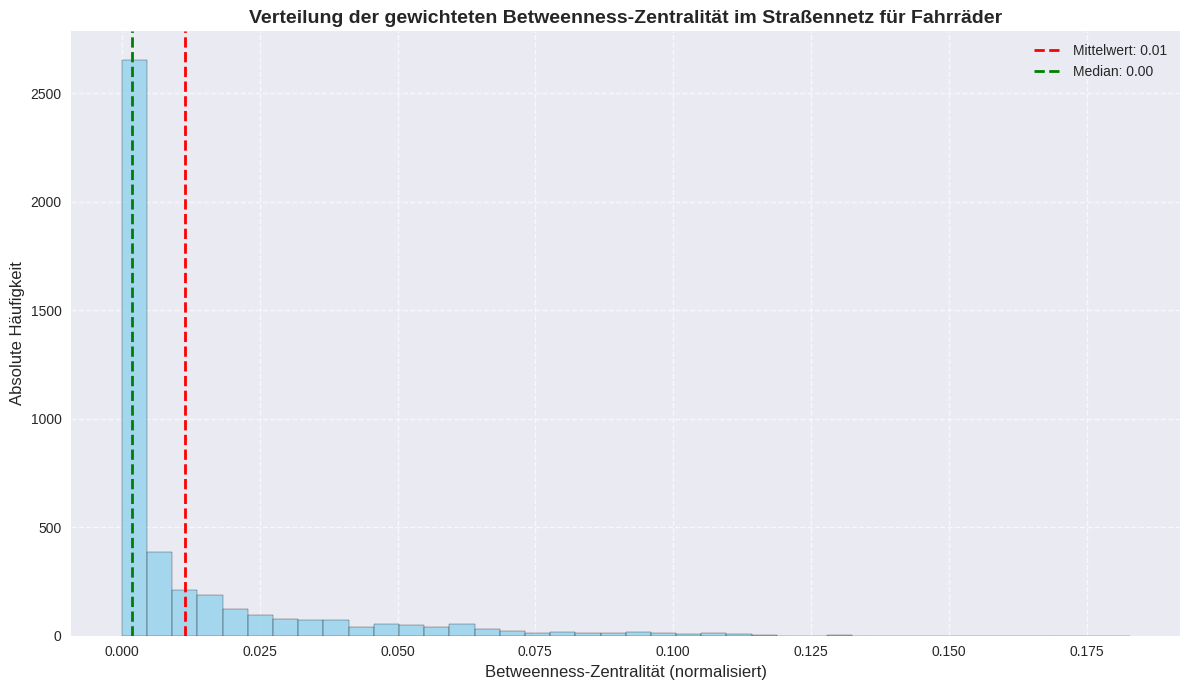

In [51]:
# Extrahieren Sie die Betweenness-Werte aus dem DataFrame
betweenness_values = df_betweenness_bike['betweenness_weighted'].values


# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(betweenness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='skyblue', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(betweenness_values)
median_value = np.median(betweenness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Beschriftungen und Titel
plt.xlabel('Betweenness-Zentralität (normalisiert)', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der gewichteten Betweenness-Zentralität im Straßennetz für Fahrräder', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=10)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/betweenness_verteilung_bike.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()



/tmp/ipykernel_25/231054047.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


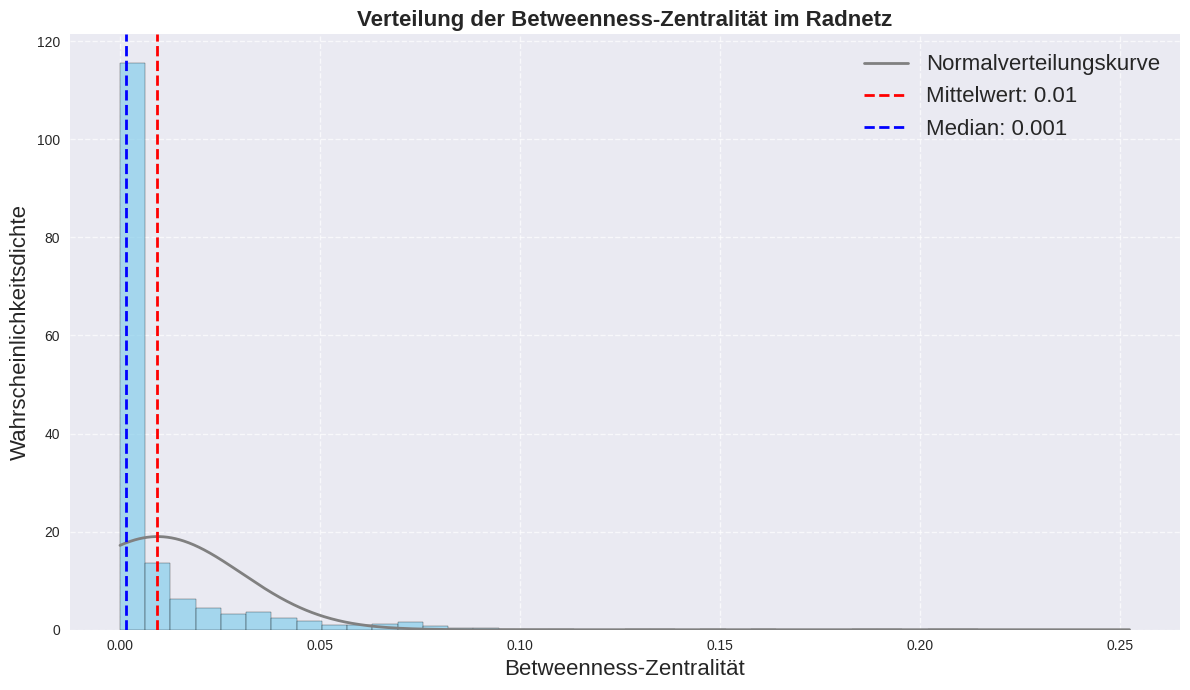

In [20]:
from scipy.stats import norm

# Betweenness-Werte extrahieren
betweenness_values = df_betweenness_bike['betweenness_unweighted'].values

# Stil setzen
plt.style.use('seaborn')

# Histogramm mit density=True (y-Achse ist Wahrscheinlichkeitsdichte)
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(
    betweenness_values, bins=40, edgecolor='black',
    alpha=0.7, color='skyblue', density=True
)

# Mittelwert und Standardabweichung berechnen
mean_value = np.mean(betweenness_values)
std_value = np.std(betweenness_values)

# Normalverteilungskurve berechnen
x = np.linspace(min(betweenness_values), max(betweenness_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Mittelwert und Median einzeichnen
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.2f}')
plt.axvline(np.median(betweenness_values), color='blue', linestyle='dashed', linewidth=2, label=f'Median: {np.median(betweenness_values):.3f}')

# Achsenbeschriftungen und Titel
plt.xlabel('Betweenness-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Betweenness-Zentralität im Radnetz', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=16)
plt.tight_layout()

# Speichern und Anzeigen
plt.savefig('Masterarbeit/betweenness_verteilung_bike_density.png', dpi=300, bbox_inches='tight')
plt.show()


### Prozentuale Anteil an kumulativer Zentralität 

#### Drive

In [23]:

# Prozentualer Anteil von 100 Knoten
total_nodes = len(G.nodes())
percentage_100 = (100 / total_nodes) * 100
print(f"Anteil von 100 Knoten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
betweenness_values = list(betweenness.values())

# Werte sortieren (absteigend)
sorted_values = sorted(betweenness_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_nodes = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_nodes

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Knoten")
    print(f"Entspricht {n/total_nodes*100:.1f}% aller Knoten\n")


Anteil von 100 Knoten am Gesamtnetzwerk: 8.3%
80% der Gesamt-Betweenness werden erreicht durch: 331 Knoten
Entspricht 27.5% aller Knoten

90% der Gesamt-Betweenness werden erreicht durch: 479 Knoten
Entspricht 39.8% aller Knoten

50% der Gesamt-Betweenness werden erreicht durch: 120 Knoten
Entspricht 10.0% aller Knoten



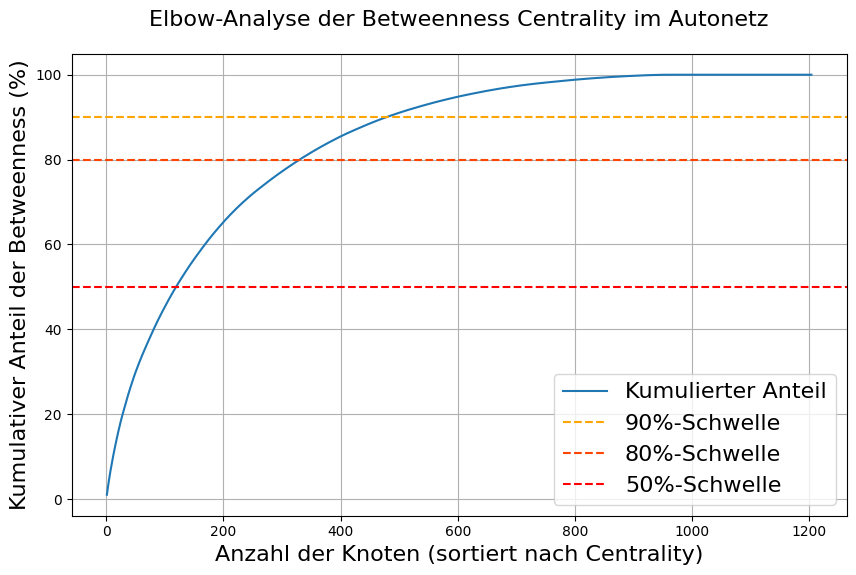

In [27]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')
plt.xlabel('Anzahl der Knoten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Elbow-Analyse der Betweenness Centrality im Autonetz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/betweeness_drive_elbow.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
def analyze_betweenness(betweenness_dict, node_count):
    # 1. Null-Werte
    zero_count = sum(1 for v in betweenness_dict.values() if abs(v) < 1e-9)
    
    # 2. Top 100 Anteil
    sorted_values = sorted(betweenness_dict.values(), reverse=True)
    total = sum(sorted_values)
    top_100 = sum(sorted_values[:100])/total * 100
    
    # 3. Normalisierungsfaktor
    norm_factor = (node_count-1)*(node_count-2)/2
    
    return {
        'zero_count': zero_count,
        'zero_percentage': zero_count/node_count*100,
        'top_100_share': top_100,
        'norm_factor': norm_factor,
        'node_count': node_count
    }

# Aufruf mit Ihren Daten
results = analyze_betweenness(betweenness_weighted, len(G.nodes()))

print(results)


# Aufruf mit Ihren Daten
results = analyze_betweenness(betweenness_weighted_all, len(G_all.nodes()))

print(results)


{'zero_count': 242, 'zero_percentage': 20.09966777408638, 'top_100_share': 39.327357488482996, 'norm_factor': 723003.0, 'node_count': 1204}
{'zero_count': 242, 'zero_percentage': 20.08298755186722, 'top_100_share': 39.327357488482996, 'norm_factor': 724206.0, 'node_count': 1205}


#### Bike

In [38]:
# Prozentualer Anteil von 100 Knoten
total_nodes = len(B.nodes())
percentage_100 = (100 / total_nodes) * 100
print(f"Anteil von 100 Knoten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
betweenness_values = list(betweenness_bike.values())

# Werte sortieren (absteigend)
sorted_values = sorted(betweenness_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_nodes = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_nodes

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Knoten")
    print(f"Entspricht {n/total_nodes*100:.1f}% aller Knoten\n")


Anteil von 100 Knoten am Gesamtnetzwerk: 2.3%
80% der Gesamt-Betweenness werden erreicht durch: 716 Knoten
Entspricht 16.7% aller Knoten

90% der Gesamt-Betweenness werden erreicht durch: 1108 Knoten
Entspricht 25.9% aller Knoten

50% der Gesamt-Betweenness werden erreicht durch: 269 Knoten
Entspricht 6.3% aller Knoten



Steigt schneller (=steiler) an als der Autograph. 90% der Gesamtbetweeness werden bereits durch 28.4% der Knoten erreicht, statt wie im Autograph durch 40.1%. Das betsätigt auch der Blick auf den Anteil der Knoten mit Betweeness gleich null: im Radgraph haben 31% der Knoten und im Autograph nur 20% der Knoten Betwenesswerte von null.

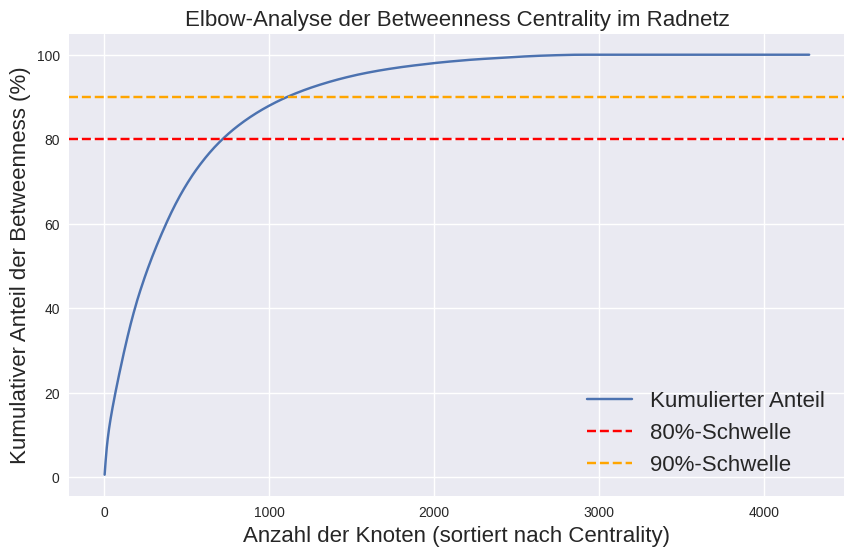

In [39]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')
plt.xlabel('Anzahl der Knoten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Elbow-Analyse der Betweenness Centrality im Radnetz', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/betweeness_bike_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
def analyze_betweenness(betweenness_dict, node_count):
    # 1. Null-Werte
    zero_count = sum(1 for v in betweenness_dict.values() if abs(v) < 1e-9)
    
    # 2. Top 100 Anteil
    sorted_values = sorted(betweenness_dict.values(), reverse=True)
    total = sum(sorted_values)
    top_100 = sum(sorted_values[:100])/total * 100
    
    # 3. Normalisierungsfaktor
    norm_factor = (node_count-1)*(node_count-2)/2
    
    return {
        'zero_count': zero_count,
        'zero_percentage': zero_count/node_count*100,
        'top_100_share': top_100,
        'norm_factor': norm_factor,
        'node_count': node_count
    }

# Aufruf mit Ihren Daten
results = analyze_betweenness(betweenness_bike_weighted, len(B.nodes()))
print(results)

# Aufruf mit Ihren Daten
results = analyze_betweenness(betweenness_bike_weighted_filtered, len(B_filtered_main.nodes()))
print(results)

# Aufruf mit Ihren Daten
results = analyze_betweenness(betweenness_bike_weighted_all, len(B_all.nodes()))
print(results)

{'zero_count': 1363, 'zero_percentage': 31.88304093567251, 'top_100_share': 19.919392624054275, 'norm_factor': 9131401.0, 'node_count': 4275}
{'zero_count': 1363, 'zero_percentage': 31.965290806754222, 'top_100_share': 19.940021534269547, 'norm_factor': 9084453.0, 'node_count': 4264}
{'zero_count': 1474, 'zero_percentage': 33.49238809361509, 'top_100_share': 19.9193884209141, 'norm_factor': 9677800.0, 'node_count': 4401}


Bei dem Graph mit allen unverbunbundenen Komponenten inkludiert, sind es insgesamt 4401 statt 4275 Knoten, das macht 126 Knoten mehr. Aber es gibt auch 1474 Knoten mit Betweeness gleich null, statt nur 1363 im verbundenen Graph, das macht 111 mehr Knoten mit einer Betweeness von null. Das sind fast die gesamten zusätzlichen Knoten und macht 33.49 % der Knoten des Graphen aus (im verbundenen Graphen sind es 31.88 %). Das zeigt, dass nahezu alle der zusätzlichen Knoten der unverbundenen Komponenten eine erwartbar kleine Betweeness-Zentralität haben und damit für die Betrachtung der globalen Zentralität vernachlässigbar sind.

In [56]:
def get_top_percent_nodes(betweenness_dict, percent):
    values = np.array(list(betweenness_dict.values()))
    threshold = np.quantile(values, 1 - percent/100)
    central_nodes = [node for node, value in betweenness_dict.items() if value >= threshold]
    total_nodes = len(betweenness_dict)
    return central_nodes, len(central_nodes) / total_nodes * 100

for perc in [1, 5, 10]:
    nodes, perc_real = get_top_percent_nodes(betweenness_bike_weighted, perc)
    print(f"Top {perc}% (Schwellenwert: {np.quantile(list(betweenness_bike_weighted.values()), 1-perc/100):.4f}): "
          f"{len(nodes)} Knoten ({perc_real:.2f}% aller Knoten)")


Top 1% (Schwellenwert: 0.0969): 43 Knoten (1.01% aller Knoten)
Top 5% (Schwellenwert: 0.0597): 214 Knoten (5.01% aller Knoten)
Top 10% (Schwellenwert: 0.0395): 428 Knoten (10.01% aller Knoten)


#### Bike weighted

In [6]:
# Graph laden und Betweenness berechnen
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

betweenness_bike_weighted = nx.betweenness_centrality(
    B, 
    weight='length',  # Attributname der Straßenlängen
    normalized=True
)

# 1. Datenvorbereitung
nodes['betweenness'] = nodes.index.map(betweenness_bike_weighted.get)
betweenness_values = nodes['betweenness'].dropna().values

mean = np.mean(betweenness_values)
std = np.std(betweenness_values)

# Z-Score Berechnung und Klassifizierung
nodes['z_score'] = (nodes['betweenness'] - mean) / std
bins = [-np.inf, -3, -2, -1, 0, 1, 2, 3, np.inf]

nodes['color_class'] = pd.cut(nodes['z_score'], bins=bins, labels=False)


# Anzahl der Kanten pro Bin berechnen
node_counts = nodes['color_class'].value_counts().sort_index()

# Optional: Als Dictionary ausgeben (für weitere Analysen)
print(node_counts.to_dict())

# Sicherstellen, dass fehlende Bins als 0 gezählt werden
node_counts = nodes['color_class'].value_counts().sort_index()
node_counts = node_counts.reindex(range(8), fill_value=0)  # Damit auch leere Bins dabei sind

# Anzahl der Kanten in Bin 6 und 7 speichern
count_bin_5 = node_counts[5]
count_bin_6 = node_counts[6]
count_bin_7 = node_counts[7]

print("Anzahl der Kanten in Bin 5:", count_bin_5)
print("Anzahl der Kanten in Bin 6:", count_bin_6)
print("Anzahl der Kanten in Bin 7:", count_bin_7)

count_total = node_counts.sum()

# Prozentualer Anteil
percent_ge1 = 100 * (count_bin_5 + count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 1: {percent_ge1:.2f}%")

# Prozentualer Anteil
percent_ge2 = 100 * (count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 2: {percent_ge2:.2f}%")

{3: 3160, 4: 574, 5: 263, 6: 167, 7: 111}
Anzahl der Kanten in Bin 5: 263
Anzahl der Kanten in Bin 6: 167
Anzahl der Kanten in Bin 7: 111
Anteil der Kanten mit z ≥ 1: 12.65%
Anteil der Kanten mit z ≥ 2: 6.50%


In [7]:
# Prozentualer Anteil von 100 Knoten
total_nodes = len(B.nodes())
percentage_100 = (100 / total_nodes) * 100
print(f"Anteil von 100 Knoten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
betweenness_values = list(betweenness_bike_weighted.values())

# Werte sortieren (absteigend)
sorted_values = sorted(betweenness_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_nodes = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_nodes

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Knoten")
    print(f"Entspricht {n/total_nodes*100:.1f}% aller Knoten\n")


Anteil von 100 Knoten am Gesamtnetzwerk: 2.3%
80% der Gesamt-Betweenness werden erreicht durch: 850 Knoten
Entspricht 19.9% aller Knoten

90% der Gesamt-Betweenness werden erreicht durch: 1213 Knoten
Entspricht 28.4% aller Knoten

50% der Gesamt-Betweenness werden erreicht durch: 353 Knoten
Entspricht 8.3% aller Knoten



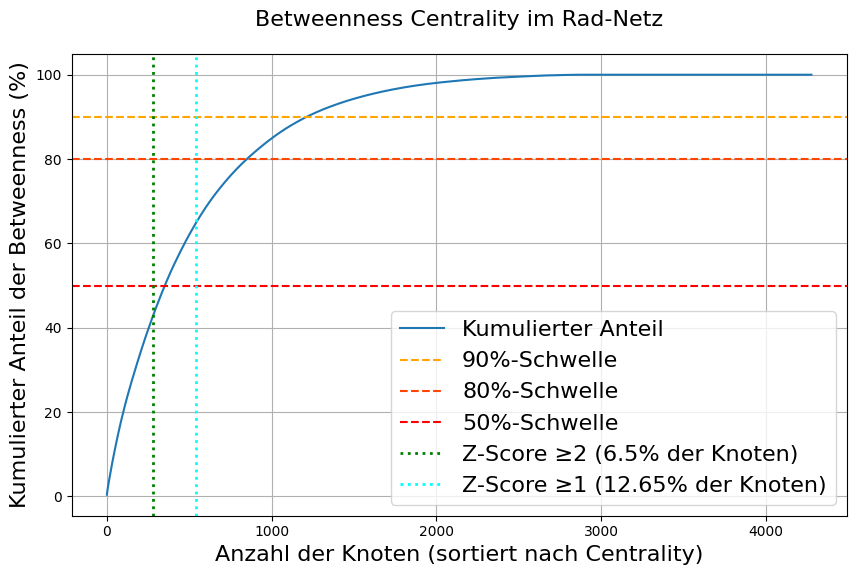

In [12]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')

# Vertikale Linie für Z-Score ≥2 
z_score_cutoff_percent = percent_ge2 # vorher berechnet
z_score_cutoff = int(len(cumulative_sum) * z_score_cutoff_percent / 100)
plt.axvline(z_score_cutoff, color='green', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥2 ({z_score_cutoff_percent:.1f}% der Knoten)')

# Vertikale Linie für Z-Score ≥1 
z_score_cutoff_percent1 = percent_ge1 # vorher berechnet
z_score_cutoff1 = int(len(cumulative_sum) * z_score_cutoff_percent1 / 100)
plt.axvline(z_score_cutoff1, color='cyan', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥1 ({z_score_cutoff_percent1:.2f}% der Knoten)')

plt.xlabel('Anzahl der Knoten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Betweenness Centrality im Rad-Netz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/betweeness_bike_kumulativ_zscore.png', dpi=300, bbox_inches='tight')

plt.show()


## Edge-Betweeness

### Histogramm

/tmp/ipykernel_25/1592524884.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


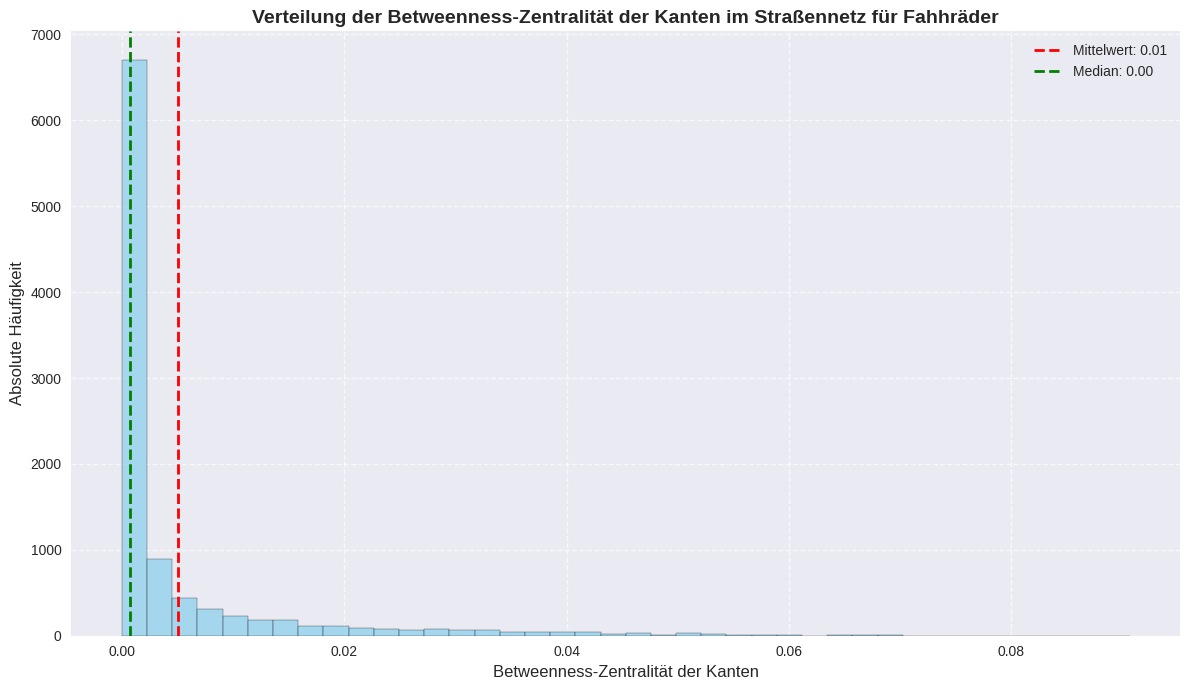

In [9]:
# Extrahieren Sie die Betweenness-Werte aus dem DataFrame
betweenness_values = df_edge_betweenness_bike['edge_betweenness_weighted'].values


# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(betweenness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='skyblue', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(betweenness_values)
median_value = np.median(betweenness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Beschriftungen und Titel
plt.xlabel('Betweenness-Zentralität der Kanten', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der Betweenness-Zentralität der Kanten im Straßennetz für Fahhräder', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=10)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('edge_betweenness_verteilung_bike.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()

### Prozentuale Anteil an kumulativer Zentralität 

#### Drive

In [7]:
# Prozentualer Anteil von 100 Knoten
total_edges = len(G.edges())
percentage_100 = (100 / total_edges) * 100
print(f"Anteil von 100 Kanten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
betweenness_values = df_edge_betweenness['edge_betweenness_weighted'].values

# Werte sortieren (absteigend)
sorted_values = sorted(betweenness_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_edges = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_edges

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Kanten")
    print(f"Entspricht {n/total_edges*100:.1f}% aller Kanten\n")


Anteil von 100 Kanten am Gesamtnetzwerk: 3.4%
80% der Gesamt-Betweenness werden erreicht durch: 728 Kanten
Entspricht 25.0% aller Kanten

90% der Gesamt-Betweenness werden erreicht durch: 1106 Kanten
Entspricht 37.9% aller Kanten

50% der Gesamt-Betweenness werden erreicht durch: 281 Kanten
Entspricht 9.6% aller Kanten



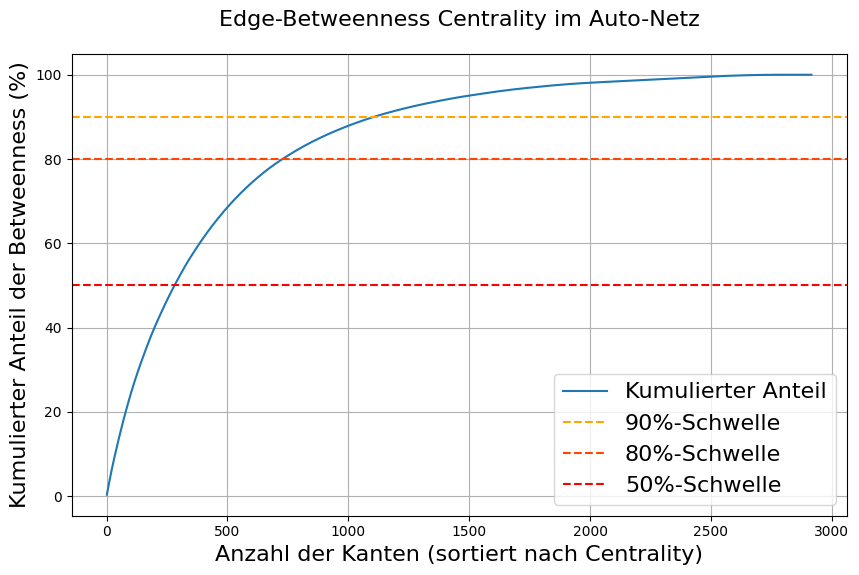

In [46]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')
plt.xlabel('Anzahl der Kanten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Edge-Betweenness Centrality im Auto-Netz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/edge_betweeness_drive_kumulativ.png', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# Graph laden und Betweenness berechnen
nodes, edges = ox.graph_to_gdfs(G)

# 1. Datenvorbereitung
edges['betweenness'] = edges.index.map(edge_betweenness_weighted.get)
betweenness_values = edges['betweenness'].dropna().values

mean = np.mean(betweenness_values)
std = np.std(betweenness_values)

# Z-Score Berechnung und Klassifizierung
edges['z_score'] = (edges['betweenness'] - mean) / std
bins = [-np.inf, -3, -2, -1, 0, 1, 2, 3, np.inf]

edges['color_class'] = pd.cut(edges['z_score'], bins=bins, labels=False)


# Anzahl der Kanten pro Bin berechnen
edge_counts = edges['color_class'].value_counts().sort_index()

# Optional: Als Dictionary ausgeben (für weitere Analysen)
print(edge_counts.to_dict())

# Sicherstellen, dass fehlende Bins als 0 gezählt werden
edge_counts = edges['color_class'].value_counts().sort_index()
edge_counts = edge_counts.reindex(range(8), fill_value=0)  # Damit auch leere Bins dabei sind

# Anzahl der Kanten in Bin 6 und 7 speichern
count_bin_5 = edge_counts[5]
count_bin_6 = edge_counts[6]
count_bin_7 = edge_counts[7]

print("Anzahl der Kanten in Bin 5:", count_bin_5)
print("Anzahl der Kanten in Bin 6:", count_bin_6)
print("Anzahl der Kanten in Bin 7:", count_bin_7)

count_total = edge_counts.sum()

# Prozentualer Anteil
percent_ge1 = 100 * (count_bin_5 + count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 1: {percent_ge1:.2f}%")

# Prozentualer Anteil
percent_ge2 = 100 * (count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 2: {percent_ge2:.2f}%")

{3: 2141, 4: 420, 5: 175, 6: 88, 7: 92}
Anzahl der Kanten in Bin 5: 175
Anzahl der Kanten in Bin 6: 88
Anzahl der Kanten in Bin 7: 92
Anteil der Kanten mit z ≥ 1: 12.17%
Anteil der Kanten mit z ≥ 2: 6.17%


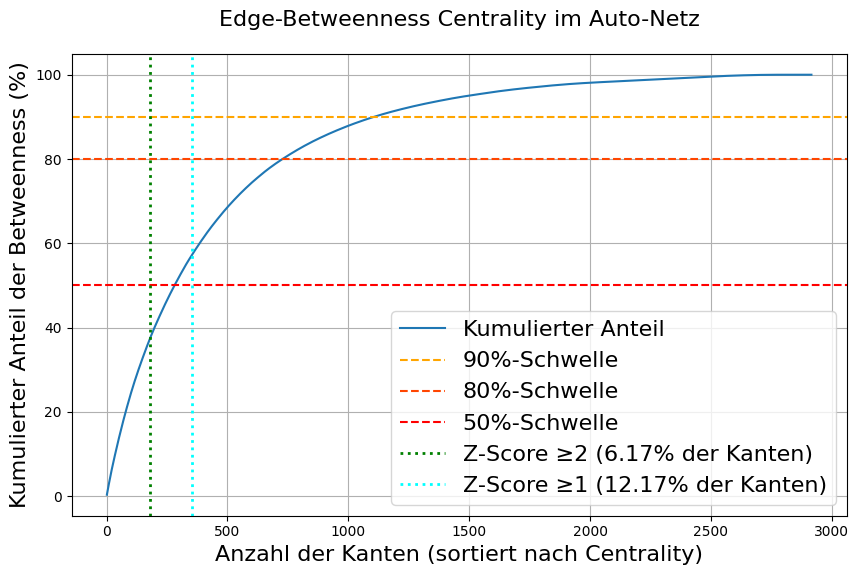

In [9]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')

# Vertikale Linie für Z-Score ≥2 
z_score_cutoff_percent = percent_ge2 # vorher berechnet
z_score_cutoff = int(len(cumulative_sum) * z_score_cutoff_percent / 100)
plt.axvline(z_score_cutoff, color='green', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥2 ({z_score_cutoff_percent:.2f}% der Kanten)')

# Vertikale Linie für Z-Score ≥1 
z_score_cutoff_percent1 = percent_ge1 # vorher berechnet
z_score_cutoff1 = int(len(cumulative_sum) * z_score_cutoff_percent1 / 100)
plt.axvline(z_score_cutoff1, color='cyan', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥1 ({z_score_cutoff_percent1:.2f}% der Kanten)')

plt.xlabel('Anzahl der Kanten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Edge-Betweenness Centrality im Auto-Netz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/edge_betweeness_drive_kumulativ_zscore.png', dpi=300, bbox_inches='tight')

plt.show()


#### Bike

In [11]:
# Prozentualer Anteil von 100 Knoten
total_edges = len(B.edges())
percentage_100 = (100 / total_edges) * 100
print(f"Anteil von 100 Kanten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
betweenness_values = df_edge_betweenness_bike['edge_betweenness_weighted'].values

# Werte sortieren (absteigend)
sorted_values = sorted(betweenness_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_edges = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_edges

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Kanten")
    print(f"Entspricht {n/total_edges*100:.1f}% aller Kanten\n")


Anteil von 100 Kanten am Gesamtnetzwerk: 1.0%
80% der Gesamt-Betweenness werden erreicht durch: 1768 Kanten
Entspricht 17.8% aller Kanten

90% der Gesamt-Betweenness werden erreicht durch: 2726 Kanten
Entspricht 27.4% aller Kanten

50% der Gesamt-Betweenness werden erreicht durch: 680 Kanten
Entspricht 6.8% aller Kanten



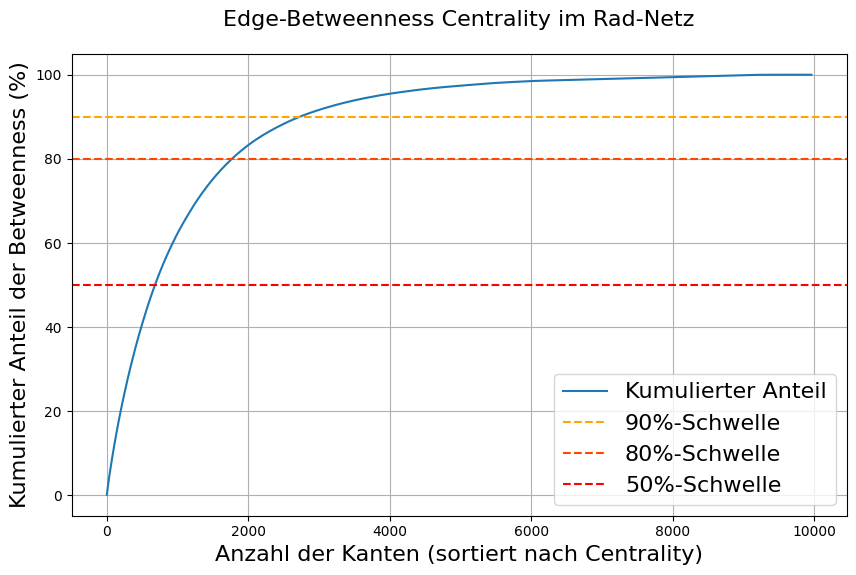

In [43]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')
plt.xlabel('Anzahl der Kanten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Edge-Betweenness Centrality im Rad-Netz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/edge_betweeness_bike_kumulativ.png', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
# Graph laden und Betweenness berechnen
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

# 1. Datenvorbereitung
edges['betweenness'] = edges.index.map(edge_betweenness_bike_weighted.get)
betweenness_values = edges['betweenness'].dropna().values

mean = np.mean(betweenness_values)
std = np.std(betweenness_values)

# Z-Score Berechnung und Klassifizierung
edges['z_score'] = (edges['betweenness'] - mean) / std
bins = [-np.inf, -3, -2, -1, 0, 1, 2, 3, np.inf]

edges['color_class'] = pd.cut(edges['z_score'], bins=bins, labels=False)


# Anzahl der Kanten pro Bin berechnen
edge_counts = edges['color_class'].value_counts().sort_index()

# Optional: Als Dictionary ausgeben (für weitere Analysen)
print(edge_counts.to_dict())

# Sicherstellen, dass fehlende Bins als 0 gezählt werden
edge_counts = edges['color_class'].value_counts().sort_index()
edge_counts = edge_counts.reindex(range(8), fill_value=0)  # Damit auch leere Bins dabei sind

# Anzahl der Kanten in Bin 6 und 7 speichern
count_bin_5 = edge_counts[5]
count_bin_6 = edge_counts[6]
count_bin_7 = edge_counts[7]

print("Anzahl der Kanten in Bin 5:", count_bin_5)
print("Anzahl der Kanten in Bin 6:", count_bin_6)
print("Anzahl der Kanten in Bin 7:", count_bin_7)

count_total = edge_counts.sum()

# Prozentualer Anteil
percent_ge1 = 100 * (count_bin_5 + count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 1: {percent_ge1:.2f}%")

# Prozentualer Anteil
percent_ge2 = 100 * (count_bin_6 + count_bin_7) / count_total
print(f"Anteil der Kanten mit z ≥ 2: {percent_ge2:.2f}%")

{3: 7729, 4: 1181, 5: 444, 6: 294, 7: 310}
Anzahl der Kanten in Bin 5: 444
Anzahl der Kanten in Bin 6: 294
Anzahl der Kanten in Bin 7: 310
Anteil der Kanten mit z ≥ 1: 10.52%
Anteil der Kanten mit z ≥ 2: 6.07%


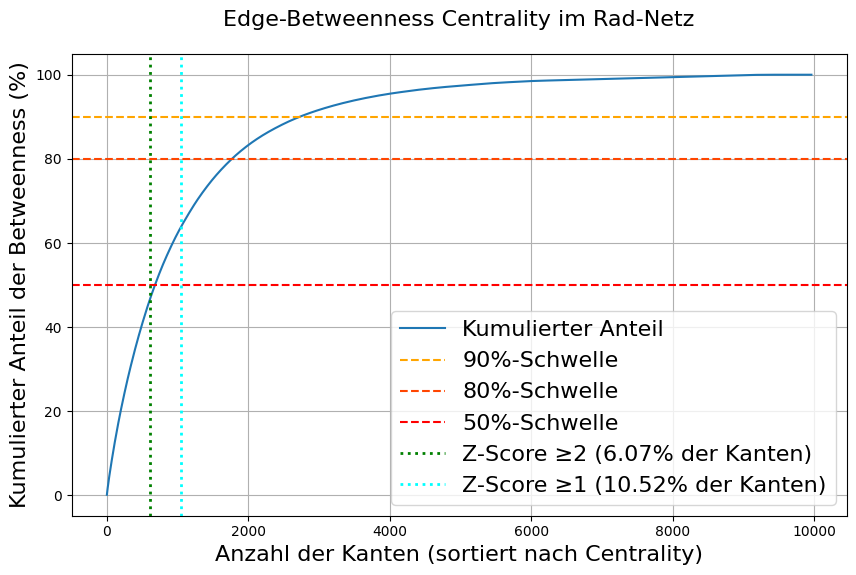

In [13]:
plt.figure(figsize=(10,6))
plt.plot(
    range(1, len(cumulative_sum)+1),
    cumulative_sum/total_sum*100,
    label='Kumulierter Anteil'
)
plt.axhline(90, color='orange', linestyle='--', label='90%-Schwelle')
plt.axhline(80, color='#FF4500', linestyle='--', label='80%-Schwelle')
plt.axhline(50, color='red', linestyle='--', label='50%-Schwelle')

# Vertikale Linie für Z-Score ≥2 
z_score_cutoff_percent = percent_ge2 # vorher berechnet
z_score_cutoff = int(len(cumulative_sum) * z_score_cutoff_percent / 100)
plt.axvline(z_score_cutoff, color='green', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥2 ({z_score_cutoff_percent:.2f}% der Kanten)')

# Vertikale Linie für Z-Score ≥1 
z_score_cutoff_percent1 = percent_ge1 # vorher berechnet
z_score_cutoff1 = int(len(cumulative_sum) * z_score_cutoff_percent1 / 100)
plt.axvline(z_score_cutoff1, color='cyan', linestyle=':', linewidth=2, 
            label=f'Z-Score ≥1 ({z_score_cutoff_percent1:.2f}% der Kanten)')

plt.xlabel('Anzahl der Kanten (sortiert nach Centrality)', fontsize=16)
plt.ylabel('Kumulierter Anteil der Betweenness (%)', fontsize=16)
plt.title('Edge-Betweenness Centrality im Rad-Netz', fontsize=16, pad=20)
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')  # Legende hinzufügen

# Speichern als PNG
plt.savefig('Masterarbeit/edge_betweeness_bike_kumulativ_zscore.png', dpi=300, bbox_inches='tight')

plt.show()


## Eigenvector

### Histogramm

#### Drive

/tmp/ipykernel_25/1655914673.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


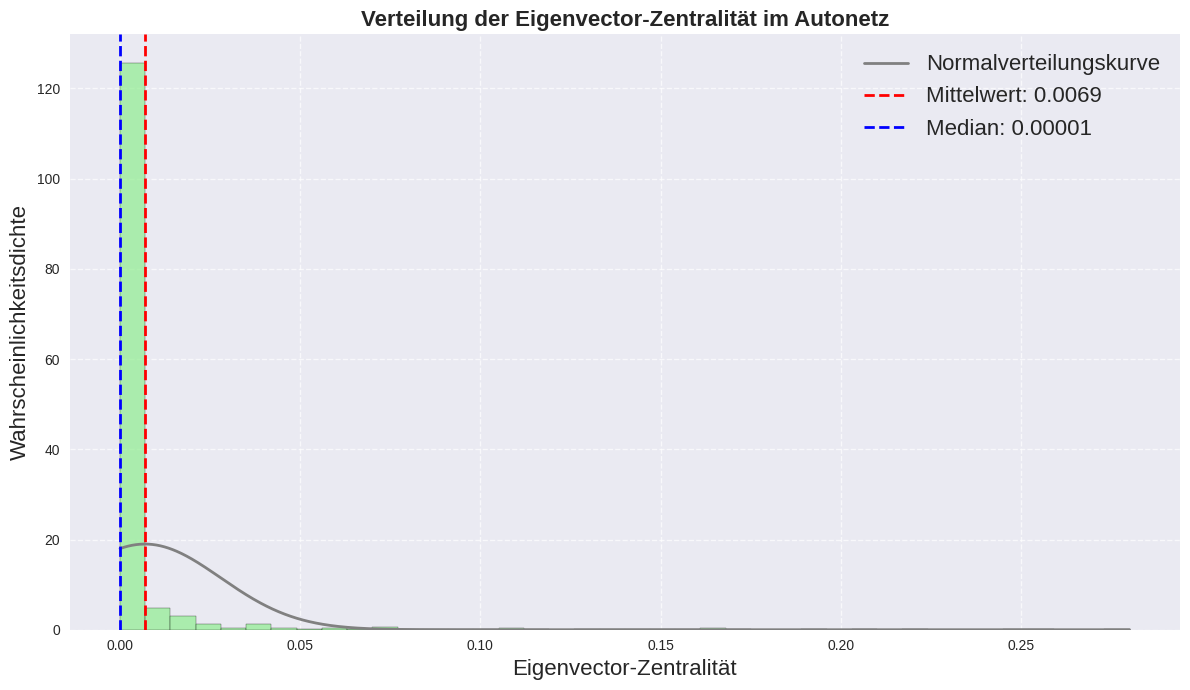

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Eigenvector-Werte aus dem DataFrame
eigenvector_values = df_eigenvector['eigenvector_unweighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(eigenvector_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='lightgreen', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(eigenvector_values)
median_value = np.median(eigenvector_values)

# Normalverteilungskurve berechnen
x = np.linspace(min(eigenvector_values), max(eigenvector_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.5f}')

# Beschriftungen und Titel
plt.xlabel('Eigenvector-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Eigenvector-Zentralität im Autonetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/eigenvector_verteilung_density.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()

/tmp/ipykernel_25/950178915.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


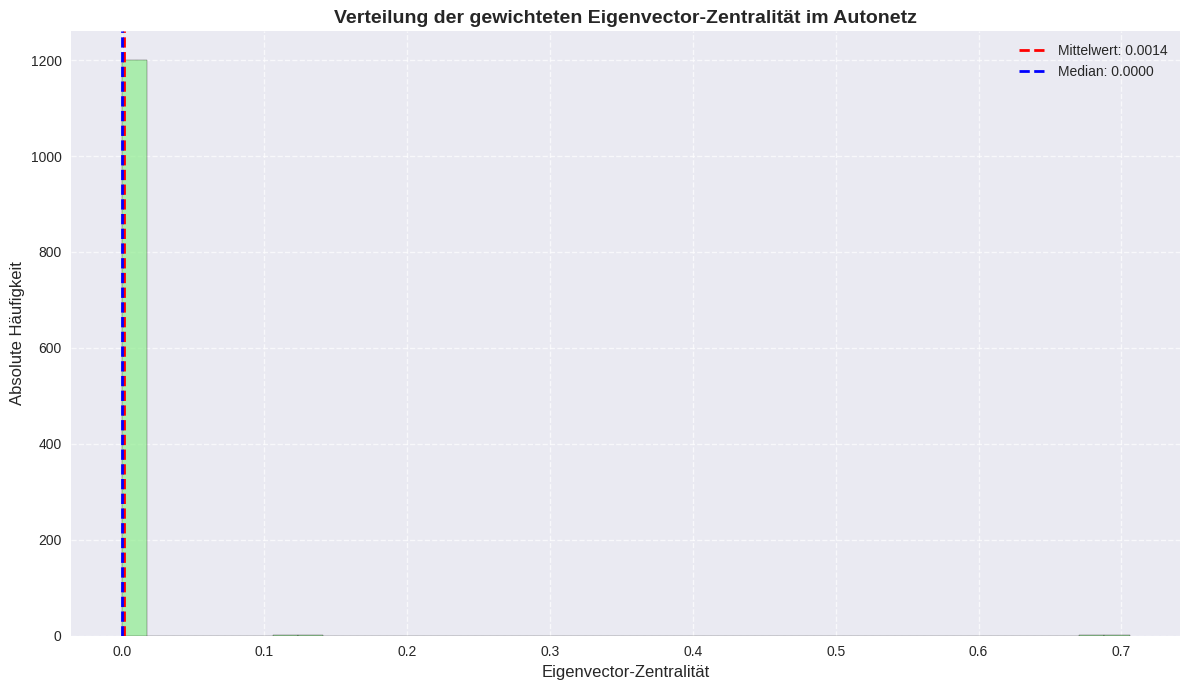

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Eigenvector-Werte aus dem DataFrame
eigenvector_values = df_eigenvector['eigenvector_weighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(eigenvector_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='lightgreen', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(eigenvector_values)
median_value = np.median(eigenvector_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Beschriftungen und Titel
plt.xlabel('Eigenvector-Zentralität', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der gewichteten Eigenvector-Zentralität im Autonetz', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=10)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('eigenvector_verteilung_gewichtet.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()

#### Bike

/tmp/ipykernel_25/2439453617.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


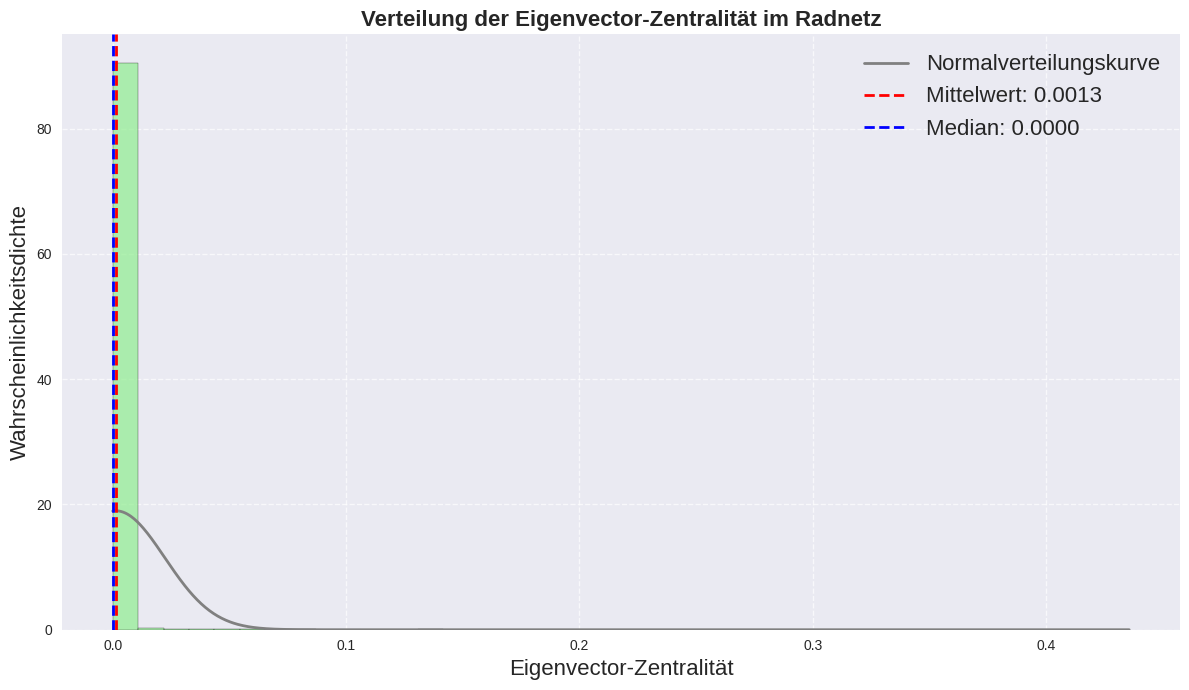

In [24]:

# Extrahieren Sie die Eigenvector-Werte aus dem DataFrame
bike_eigenvector_values = df_eigenvector_bike['eigenvector'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(bike_eigenvector_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='lightgreen', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(bike_eigenvector_values)
median_value = np.median(bike_eigenvector_values)

# Normalverteilungskurve berechnen
x = np.linspace(min(bike_eigenvector_values), max(bike_eigenvector_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Beschriftungen und Titel
plt.xlabel('Eigenvector-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Eigenvector-Zentralität im Radnetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/bike_eigenvector_verteilung_density.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


## Closeness

### Histogramm

#### Drive

/tmp/ipykernel_25/1387761549.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


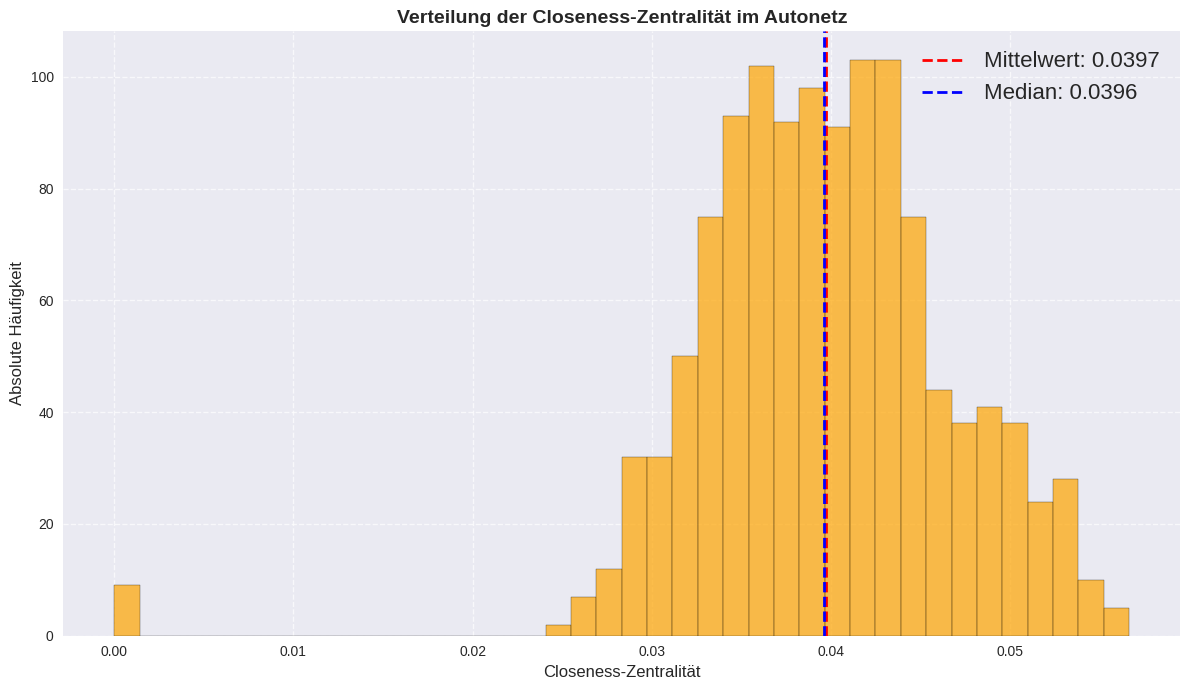

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Closeness-Werte aus dem DataFrame
closeness_values = df_closeness['closeness_unweighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(closeness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='orange', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(closeness_values)
median_value = np.median(closeness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Beschriftungen und Titel
plt.xlabel('Closeness-Zentralität', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der Closeness-Zentralität im Autonetz', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/closeness_verteilung.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


/tmp/ipykernel_25/510625920.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


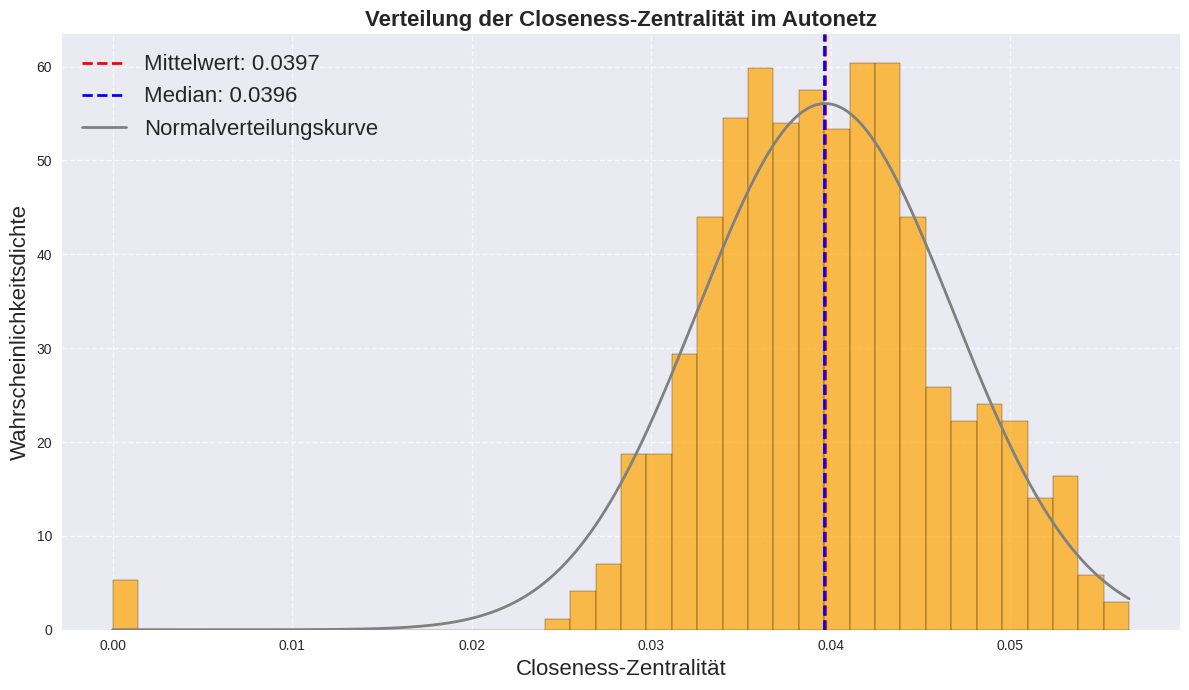

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Closeness-Werte aus dem DataFrame
closeness_values = df_closeness['closeness_unweighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(closeness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='orange', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(closeness_values)
median_value = np.median(closeness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Normalverteilungskurve berechnen
std_value = np.std(closeness_values)
x = np.linspace(min(closeness_values), max(closeness_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Beschriftungen und Titel
plt.xlabel('Closeness-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Closeness-Zentralität im Autonetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/closeness_verteilung_mit_Normalverteilung.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


#### Bike

/tmp/ipykernel_26/3504529288.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


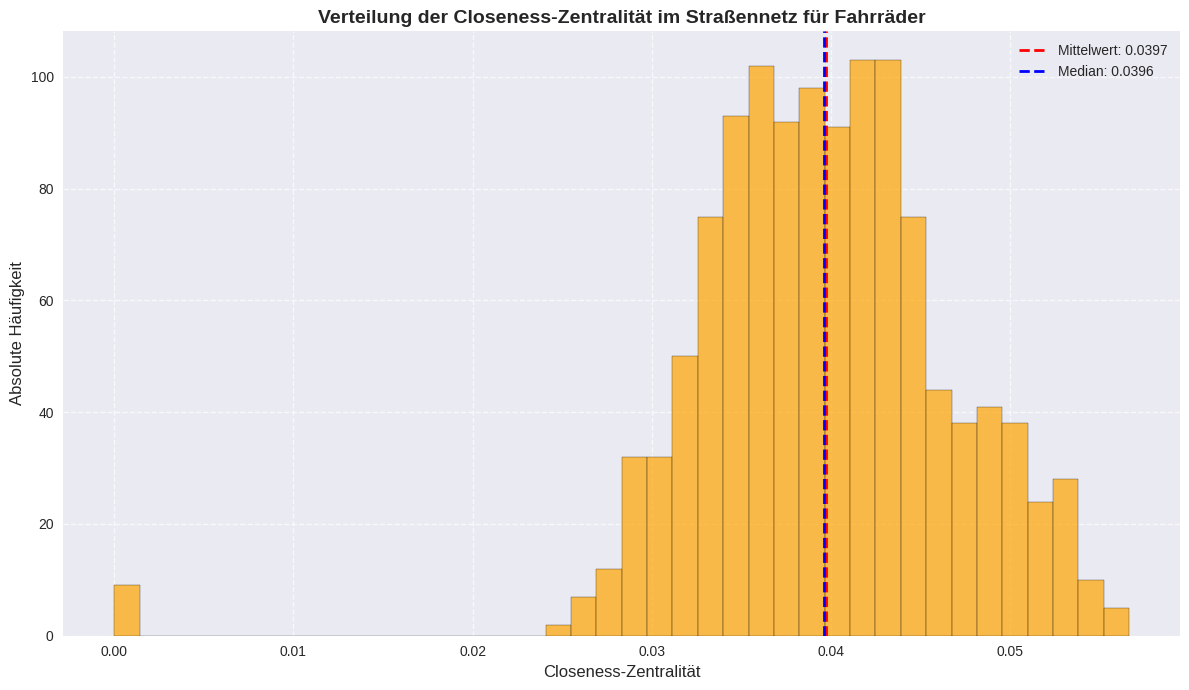

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Closeness-Werte aus dem DataFrame
bike_closeness_values = df_closeness_bike['closeness_unweighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(bike_closeness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='orange', density=False)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(bike_closeness_values)
median_value = np.median(bike_closeness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Beschriftungen und Titel
plt.xlabel('Closeness-Zentralität', fontsize=12)
plt.ylabel('Absolute Häufigkeit', fontsize=12)
plt.title('Verteilung der Closeness-Zentralität im Straßennetz für Fahrräder', fontsize=14, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=10)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/bike_closeness_verteilung.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


/tmp/ipykernel_25/3581937059.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


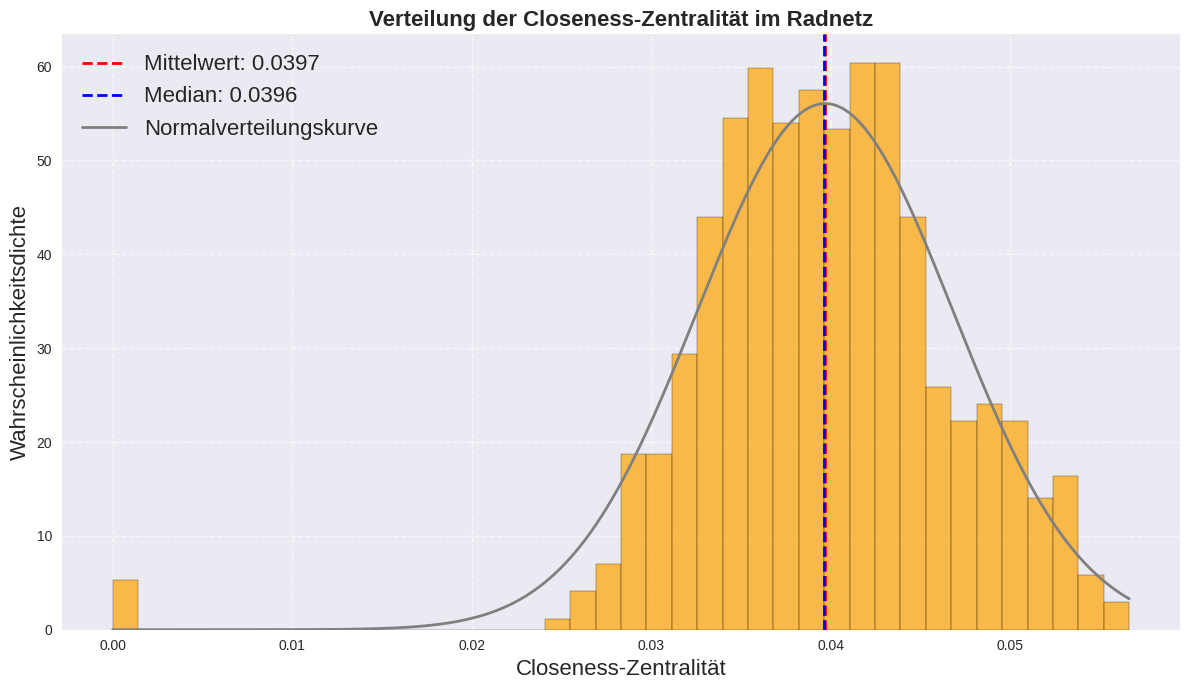

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extrahieren Sie die Closeness-Werte aus dem DataFrame
bike_closeness_values = df_closeness_bike['closeness_unweighted'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(bike_closeness_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='orange', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(bike_closeness_values)
median_value = np.median(bike_closeness_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Normalverteilungskurve berechnen
std_value = np.std(bike_closeness_values)
x = np.linspace(min(bike_closeness_values), max(bike_closeness_values), 1000)
pdf = norm.pdf(x, loc=mean_value, scale=std_value)
plt.plot(x, pdf, color='grey', linewidth=2, label='Normalverteilungskurve')

# Beschriftungen und Titel
plt.xlabel('Closeness-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Closeness-Zentralität im Radnetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/bike_closeness_verteilung_mit_Normalverteilung.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


## Degree

### Histogramm

/tmp/ipykernel_25/2941618031.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


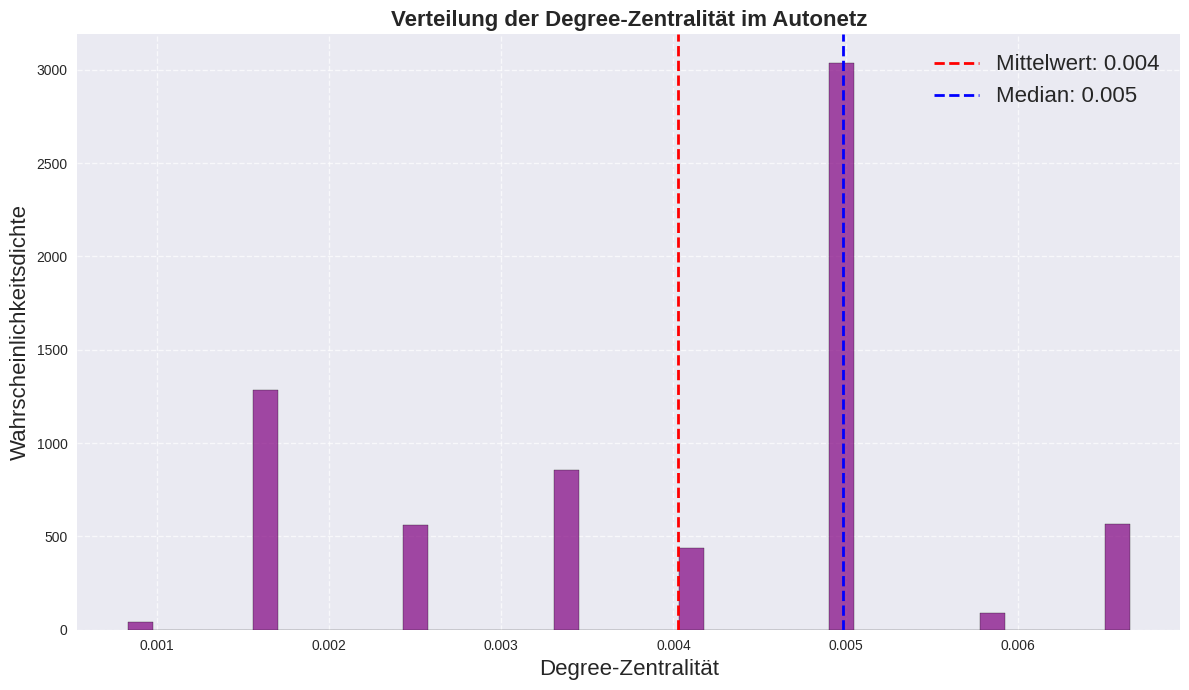

In [62]:
# Berechne Degree-Zentralität für G
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
degree = nx.degree_centrality(G)

# Erstellen Sie den DataFrame
df_degree = pd.DataFrame.from_dict(degree, orient='index', columns=['degree_centrality'])

# Extrahieren Sie die Degree-Werte aus dem DataFrame
degree_values = df_degree['degree_centrality'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(degree_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='purple', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(degree_values)
median_value = np.median(degree_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.3f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.3f}')

# Beschriftungen und Titel
plt.xlabel('Degree-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Degree-Zentralität im Autonetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/degree_verteilung_density.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()



/tmp/ipykernel_25/232868322.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


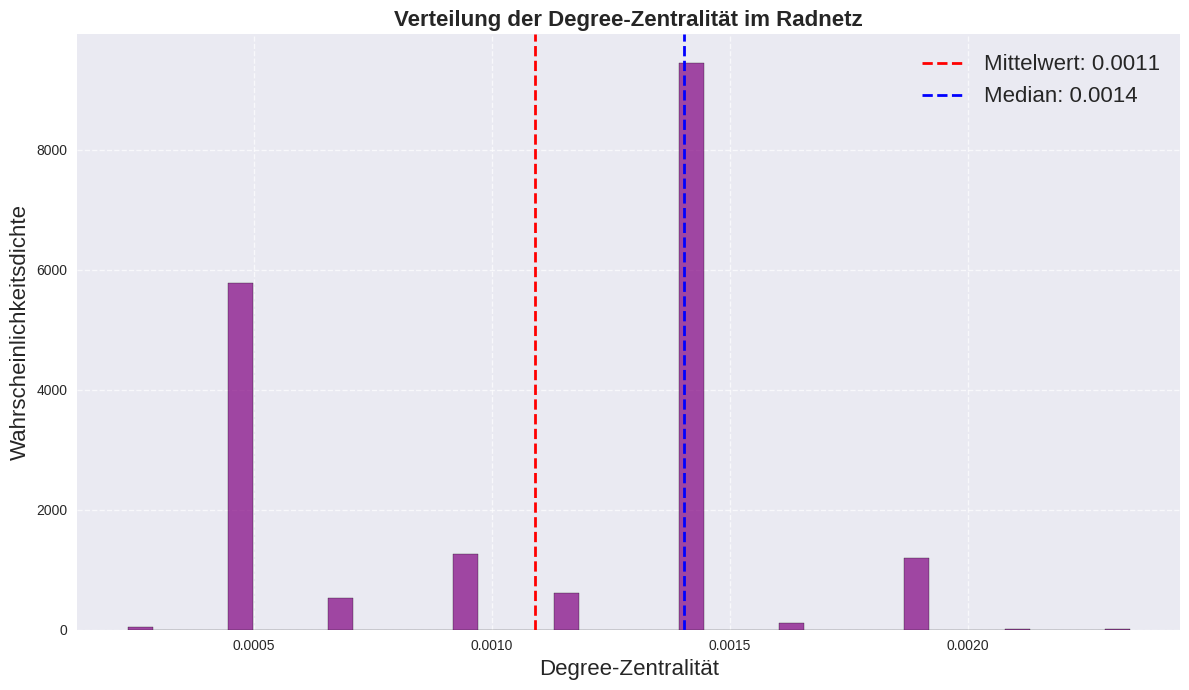

In [63]:
# Berechne Degree-Zentralität
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
bike_degree = nx.degree_centrality(B)

# Erstellen Sie den DataFrame
df_bike_degree = pd.DataFrame.from_dict(bike_degree, orient='index', columns=['degree_centrality'])

# Extrahieren Sie die Degree-Werte aus dem DataFrame
bike_degree_values = df_bike_degree['degree_centrality'].values

# Erstellen der Figur mit verbesserter Größe
plt.figure(figsize=(12, 7))

# Verwenden eines ansprechenderen Stils
plt.style.use('seaborn')

# Erstellen des Histogramms mit verbesserten Parametern
n, bins, patches = plt.hist(bike_degree_values, bins=40, edgecolor='black', 
                            alpha=0.7, color='purple', density=True)

# Berechnen des Mittelwerts und Medians
mean_value = np.mean(bike_degree_values)
median_value = np.median(bike_degree_values)

# Hinzufügen von vertikalen Linien für Mittelwert und Median
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_value:.4f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.4f}')

# Beschriftungen und Titel
plt.xlabel('Degree-Zentralität', fontsize=16)
plt.ylabel('Wahrscheinlichkeitsdichte', fontsize=16)
plt.title('Verteilung der Degree-Zentralität im Radnetz', fontsize=16, fontweight='bold')

# Gitternetz
plt.grid(True, linestyle='--', alpha=0.7)

# Legende hinzufügen
plt.legend(fontsize=16)

# Enge Layout-Anpassung
plt.tight_layout()

# Speichern als PNG
plt.savefig('Masterarbeit/bike_degree_verteilung_density.png', dpi=300, bbox_inches='tight')

# Anzeigen des Diagramms
plt.show()


### Prozentuale Anteil an kumulativer Zentralität 

In [4]:
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
degree = nx.degree_centrality(G)

# Prozentualer Anteil von 100 Knoten
total_nodes = len(G.nodes())
percentage_100 = (100 / total_nodes) * 100
print(f"Anteil von 100 Knoten am Gesamtnetzwerk: {percentage_100:.1f}%")

# Kumulative Betweenness-Berechnung
degree_values = list(degree.values())

# Werte sortieren (absteigend)
sorted_values = sorted(degree_values, reverse=True)

# Kumulative Summe berechnen
cumulative_sum = np.cumsum(sorted_values)
total_sum = cumulative_sum[-1]

# Prozentschwellen finden
def find_threshold(percentage):
    threshold = total_sum * (percentage / 100)
    num_nodes = np.argmax(cumulative_sum >= threshold) + 1  # +1 wegen 0-basierter Indexierung
    return num_nodes

for perc in [80, 90, 50]:
    n = find_threshold(perc)
    print(f"{perc}% der Gesamt-Betweenness werden erreicht durch: {n} Knoten")
    print(f"Entspricht {n/total_nodes*100:.1f}% aller Knoten\n")


Anteil von 100 Knoten am Gesamtnetzwerk: 8.3%
80% der Gesamt-Betweenness werden erreicht durch: 771 Knoten
Entspricht 64.0% aller Knoten

90% der Gesamt-Betweenness werden erreicht durch: 930 Knoten
Entspricht 77.2% aller Knoten

50% der Gesamt-Betweenness werden erreicht durch: 451 Knoten
Entspricht 37.5% aller Knoten



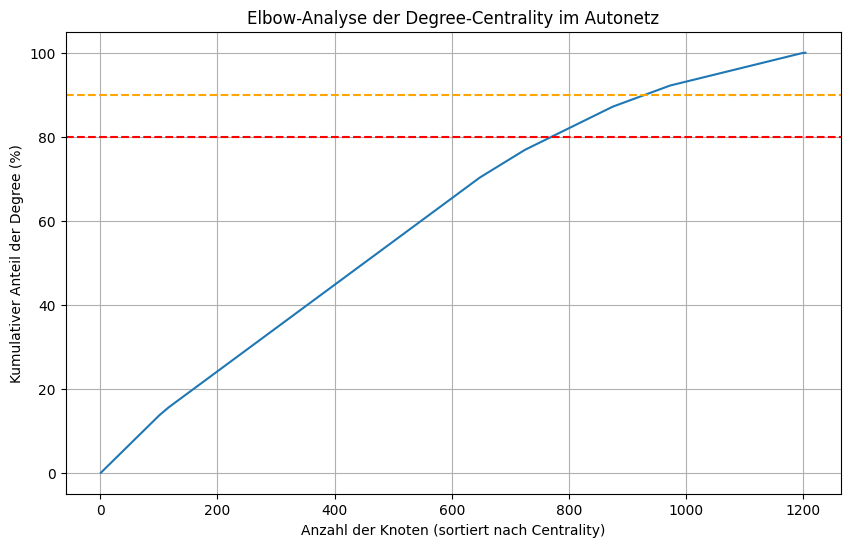

In [5]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_sum)+1), cumulative_sum/total_sum*100)
plt.axhline(80, color='red', linestyle='--')
plt.axhline(90, color='orange', linestyle='--')
plt.xlabel('Anzahl der Knoten (sortiert nach Centrality)')
plt.ylabel('Kumulativer Anteil der Degree (%)')
plt.title('Elbow-Analyse der Degree-Centrality im Autonetz')
plt.grid(True)
plt.show()